# Exercise 20: Classification of LIGO data

All experiments have selection effects. Some sources are easier to detect than others which distorts the population of sources we observe (this crucial in astronomy! Surveys are typically flux limited). In order to decided if a feature in the observed population of objects is telling us something new about reality, we need to understand and model our selection effects (for instance: it would be wrong to say that all stars are close by just because we can't observe those that are very far!). 
 
**The goal here is to machine-learn the LIGO detectability: can we *predict* if a gravitational-wave source will be detected?**  

[This dataset](https://github.com/dgerosa/pdetclassifier/releases/download/v0.2/sample_2e7_design_precessing_higherordermodes_3detectors.h5) contains simulated gravitational-wave signals from merging black holes (careful the file size is >1 GB). You can read this data format with `h5py`.

In particular, each source has the following features:
- `mtot`: the total mass of the binary
- `q`: the mass ratio
- `chi1x`, `chi1y`, `chi1z`, `chi2x`, `chi2y`, `chi2z`: the components of the black-hole spins in a suitable reference frame.
- `ra`, `dec`: the location of the source in the sky
- `iota`: the inclination of the orbital plane'
- `psi`: the polarization angle (gravitational waves have two polarization states much like light)
- `z`: the redshift

The detectability is defined using the `snr` (signal-to-noise ratio) computed with a state-of-the-art model of the LIGO/Virgo detector network. Some (many?) of you will have studied this in Sesana's gravitational-wave course; [see here](https://arxiv.org/abs/1908.11170) for a nice write-up. All you need to know now is that we threshold the `snr` values and assume that LIGO will (not) see a source if `snr`>12 (`snr`<12). The resulting 0-1 labels are reported in the `det` attribute in the dataset.

Today's task is to train a classifier (you decide which one!) and separate sources that are detectables from those that aren't. 

Be creative! This is a challenge! Let's see who gets the  higher completeness and/or the smaller contamination (on a validation set, of course! Careful with overfitting here!).

*Tips*:
- You can downsample the data for debugging purposes
- You can also use only some of the features. By experience, the most important ones are those involving masses and redshift.

---


In [1]:
from __future__ import print_function
import numpy as np
import pylab as plt
import h5py
import corner
from cycler import cycler
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_curve,precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_validate


from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier


from astroML.utils import pickle_results

%config InlineBackend.figure_format='retina'

In [2]:
file = '../../temp/LIGO_data.h5'
data = h5py.File(file, 'r')

In [4]:
X=[]
keys = ['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec', 'iota', 'mtot', 'psi', 'q', 'ra','z']
number_of_points = int(1e5)

for key  in keys:
    X.append(data[key][:number_of_points])
    
X = np.array(X).T
y = np.array(data['det'][:number_of_points])


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.3, random_state=404)

# Scaling data after split to avoid information leakage from test 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

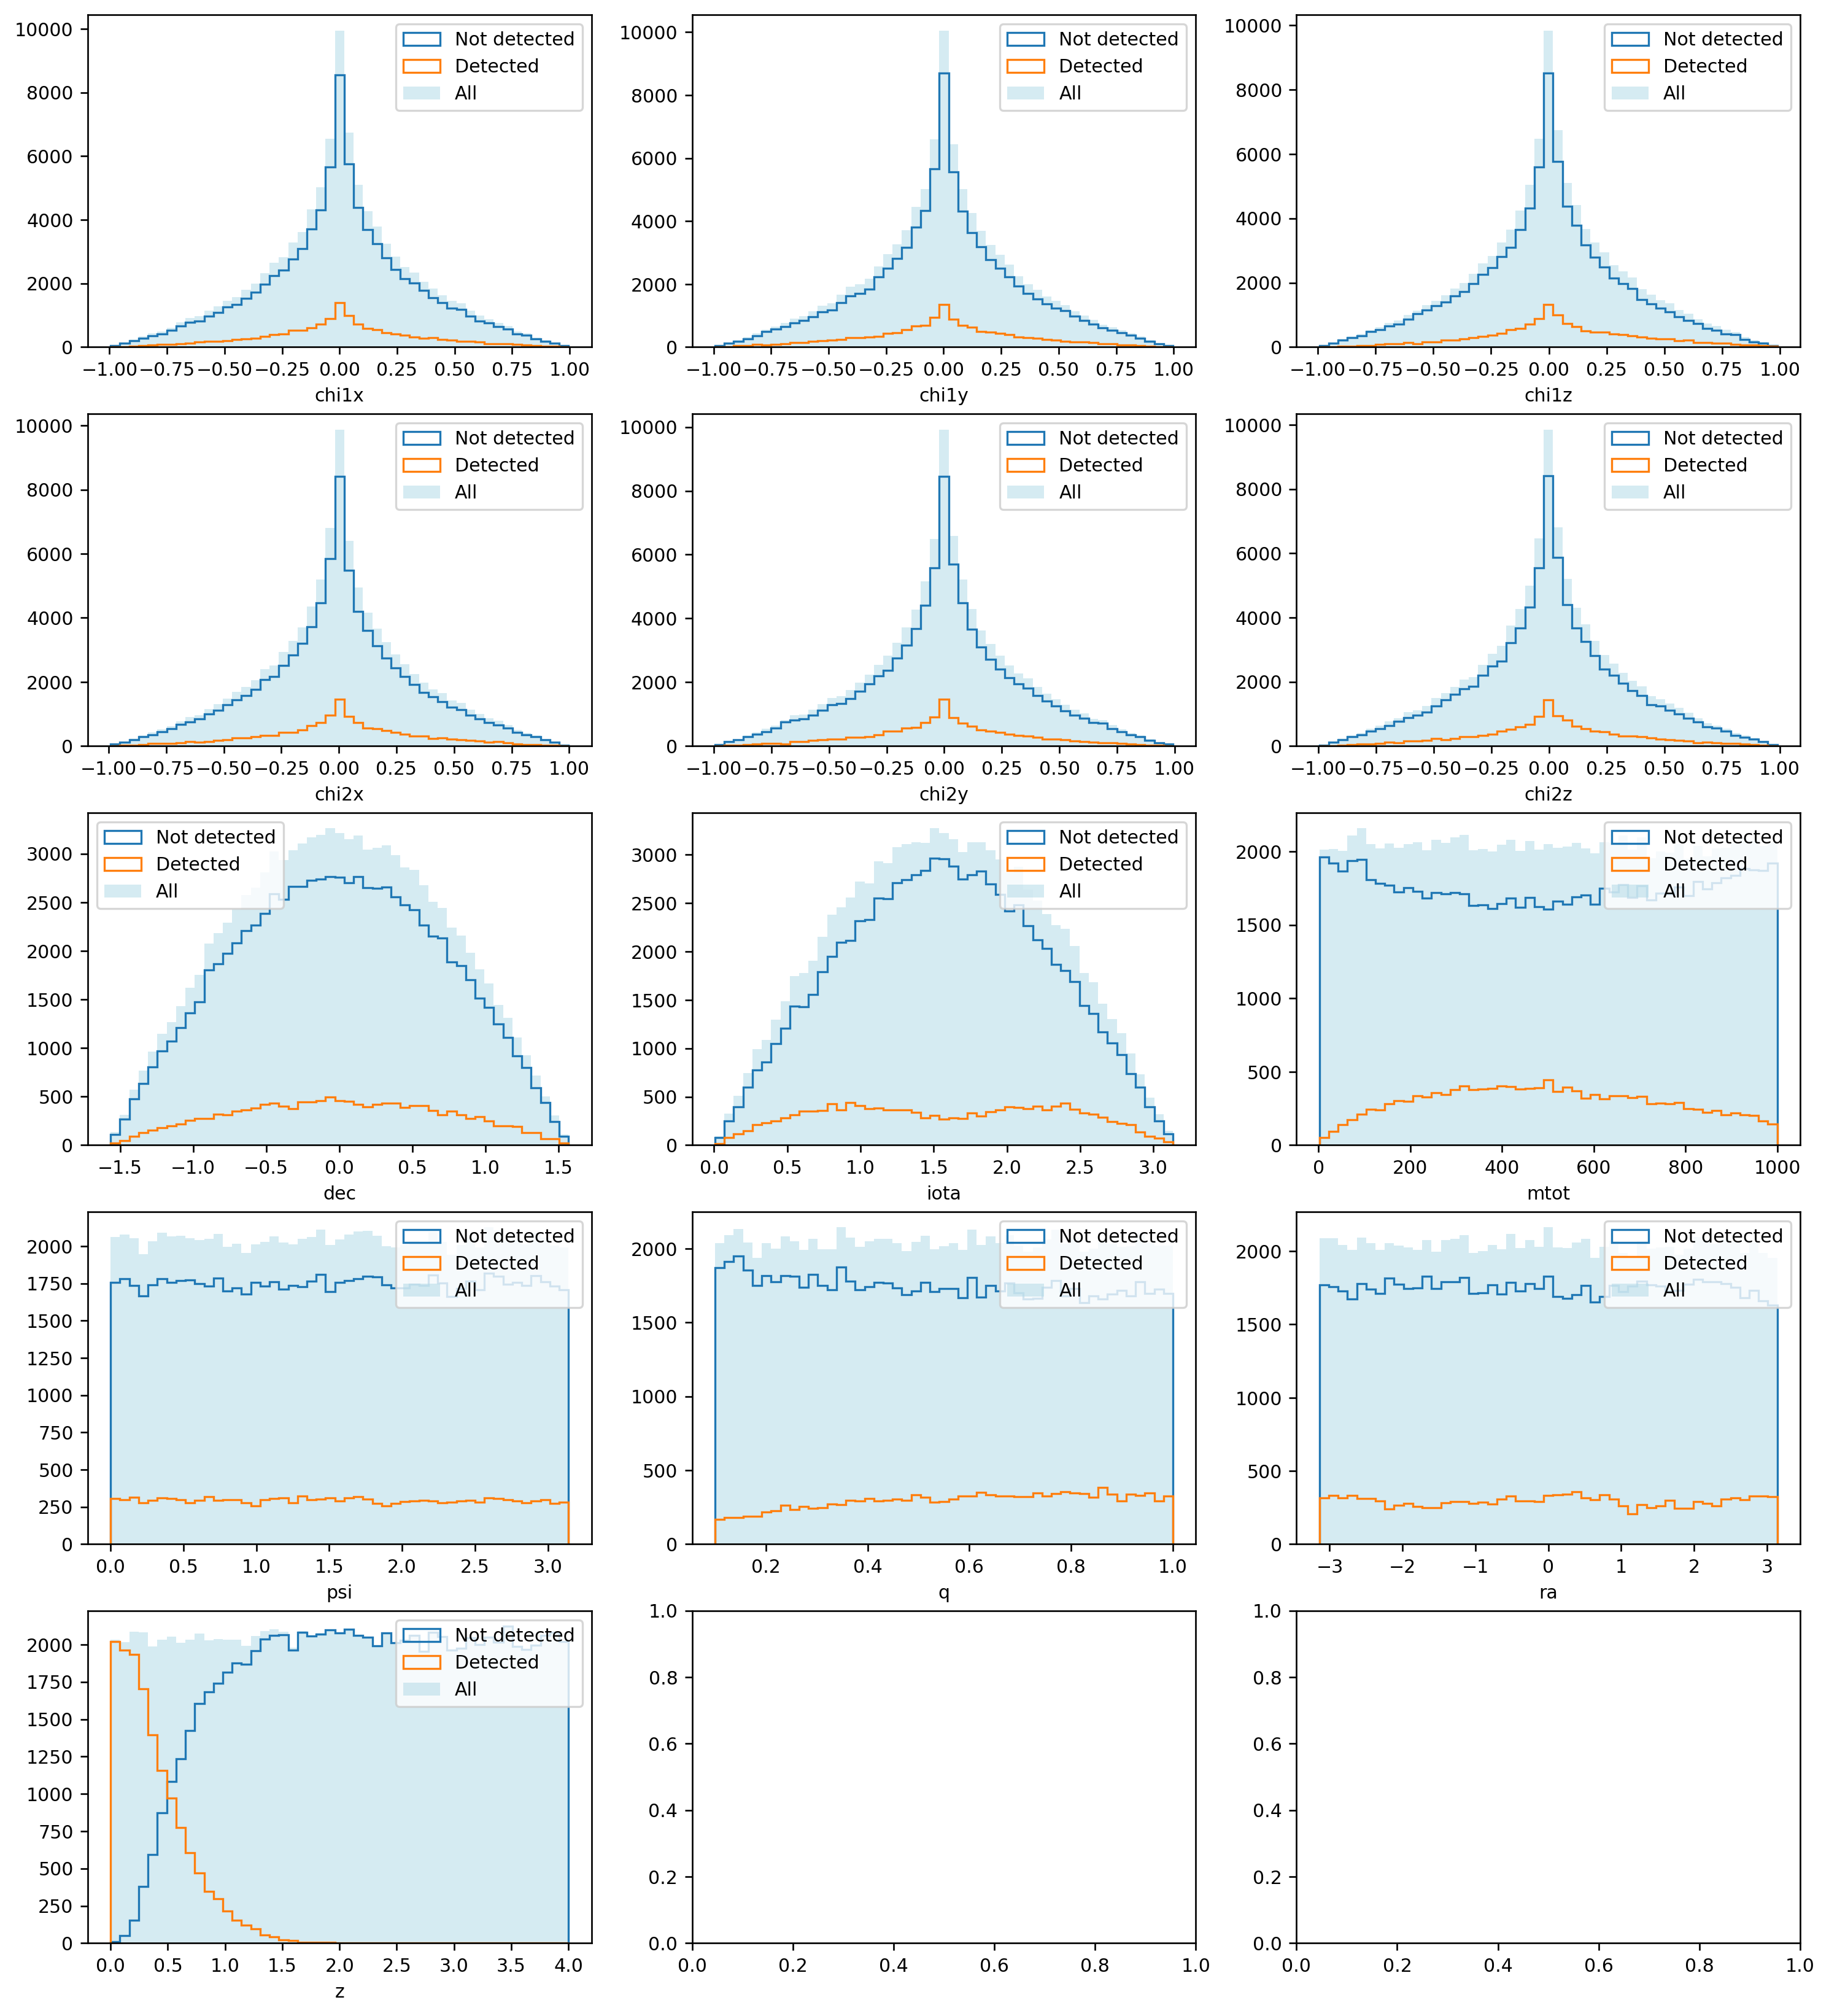

In [6]:
#-------  Plt params  ----------------
plt.rc('figure', figsize=(15,17), dpi=120)
plt.rcParams.update({'font.size': 9})
#--------------------------------------------

fig, axs = plt.subplots(5,3)

bins = np.linspace(-0.5, 3, 100)

for ax,feature, name in zip(axs.flatten() ,X.T, keys):
    bins = np.linspace(np.min(feature), np.max(feature), 50)
    ax.hist(feature[y==0], bins=bins, histtype = 'step', label = 'Not detected', lw=1)
    ax.hist(feature[y==1], bins=bins, histtype = 'step', label = 'Detected', lw=1)
    ax.hist(feature, bins=bins, label = 'All', color='lightblue', alpha=0.5,)
    ax.legend()
    ax.set_xlabel(name)
    
plt.tight_layout;

From the distributions it seems that the most informative features for a classifier are:
- z
- mtot
- q
- iota
- ra

Other features have basically identical distributions for detectable and not detectable sources.

In [6]:
# data set of only useful features
Z=[]
keys_z = ['z', 'mtot', 'q', 'iota', 'ra']
number_of_points = int(1e5)

for key  in keys_z:
    Z.append(data[key][:number_of_points])
    
Z = np.array(Z).T
yz = np.array(data['det'][:number_of_points])

In [7]:
scalerz = StandardScaler()


Z_train, Z_test, yz_train, yz_test = train_test_split(Z, yz, test_size=0.3, random_state=42)

Z_train = scalerz.fit_transform(Z_train)
Z_test = scalerz.transform(Z_test)

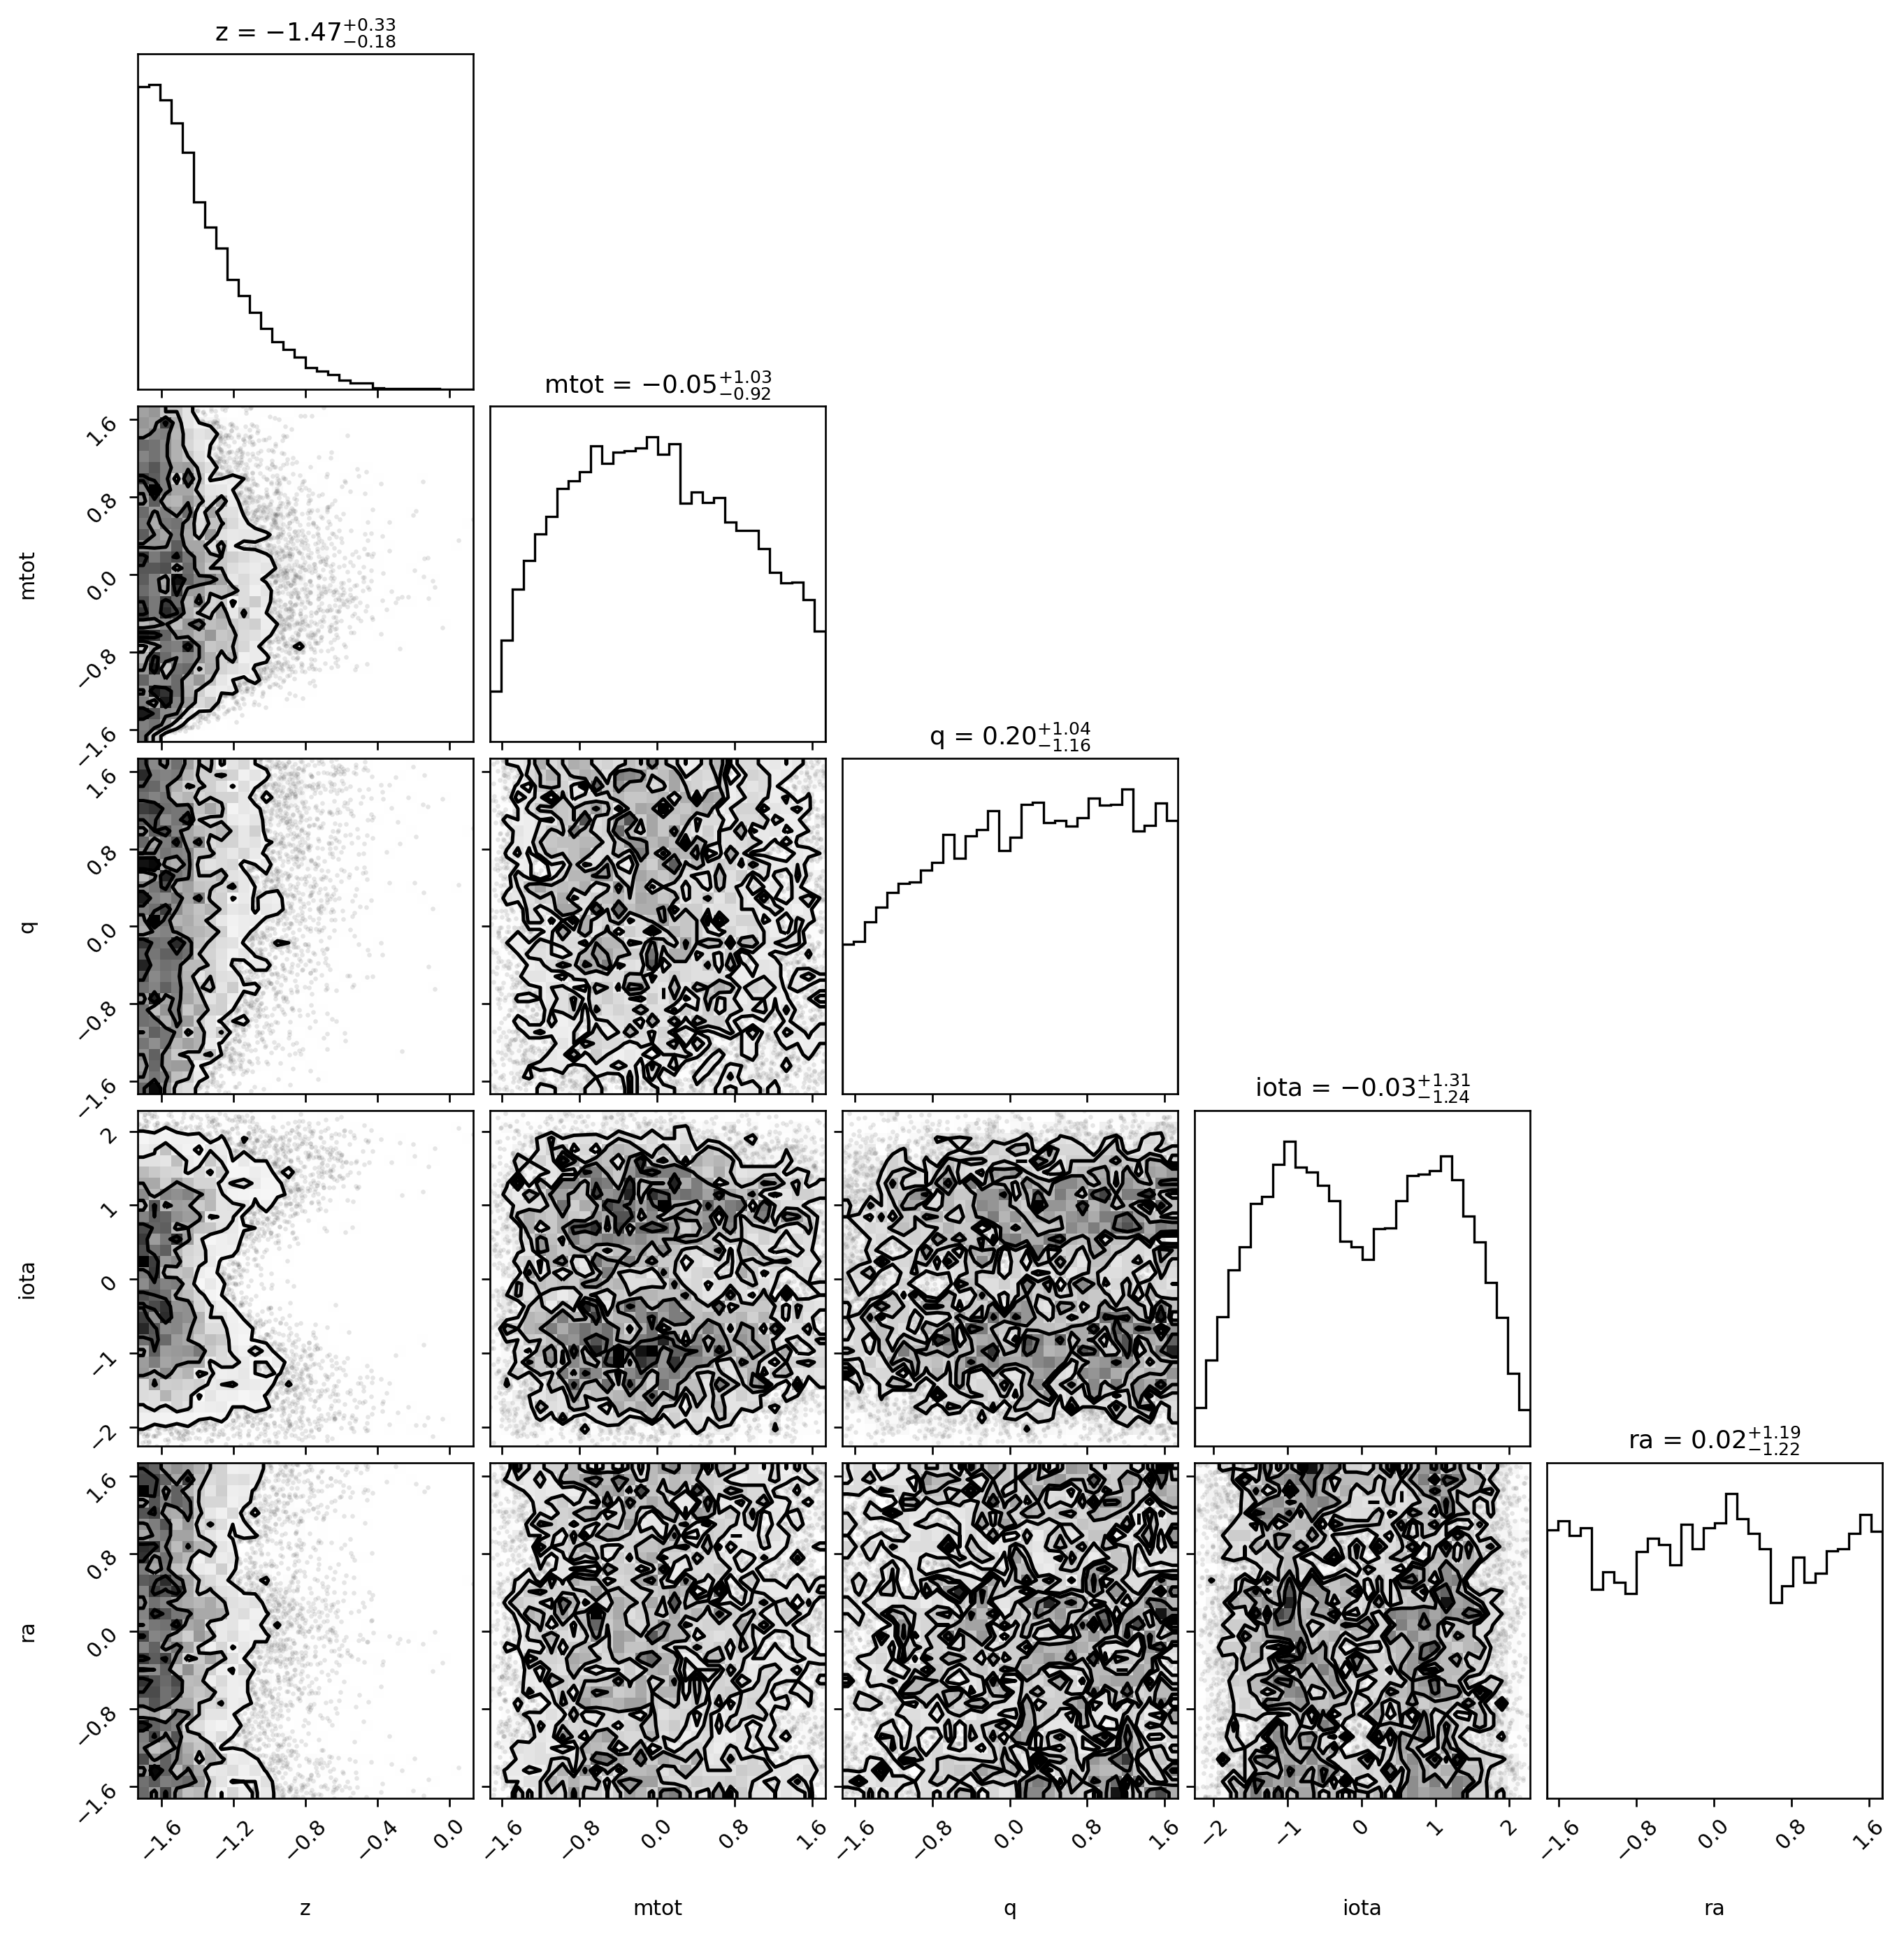

In [9]:
corner.corner(Z_train[yz_train==1], labels=keys_z, show_titles=True, bins=30);
# corner.corner(X, labels = keys, show_titles=True);


No particular correlations are found between features for both detectable and not-detectable sources.

---

## PCA
Try PCA to ease classification

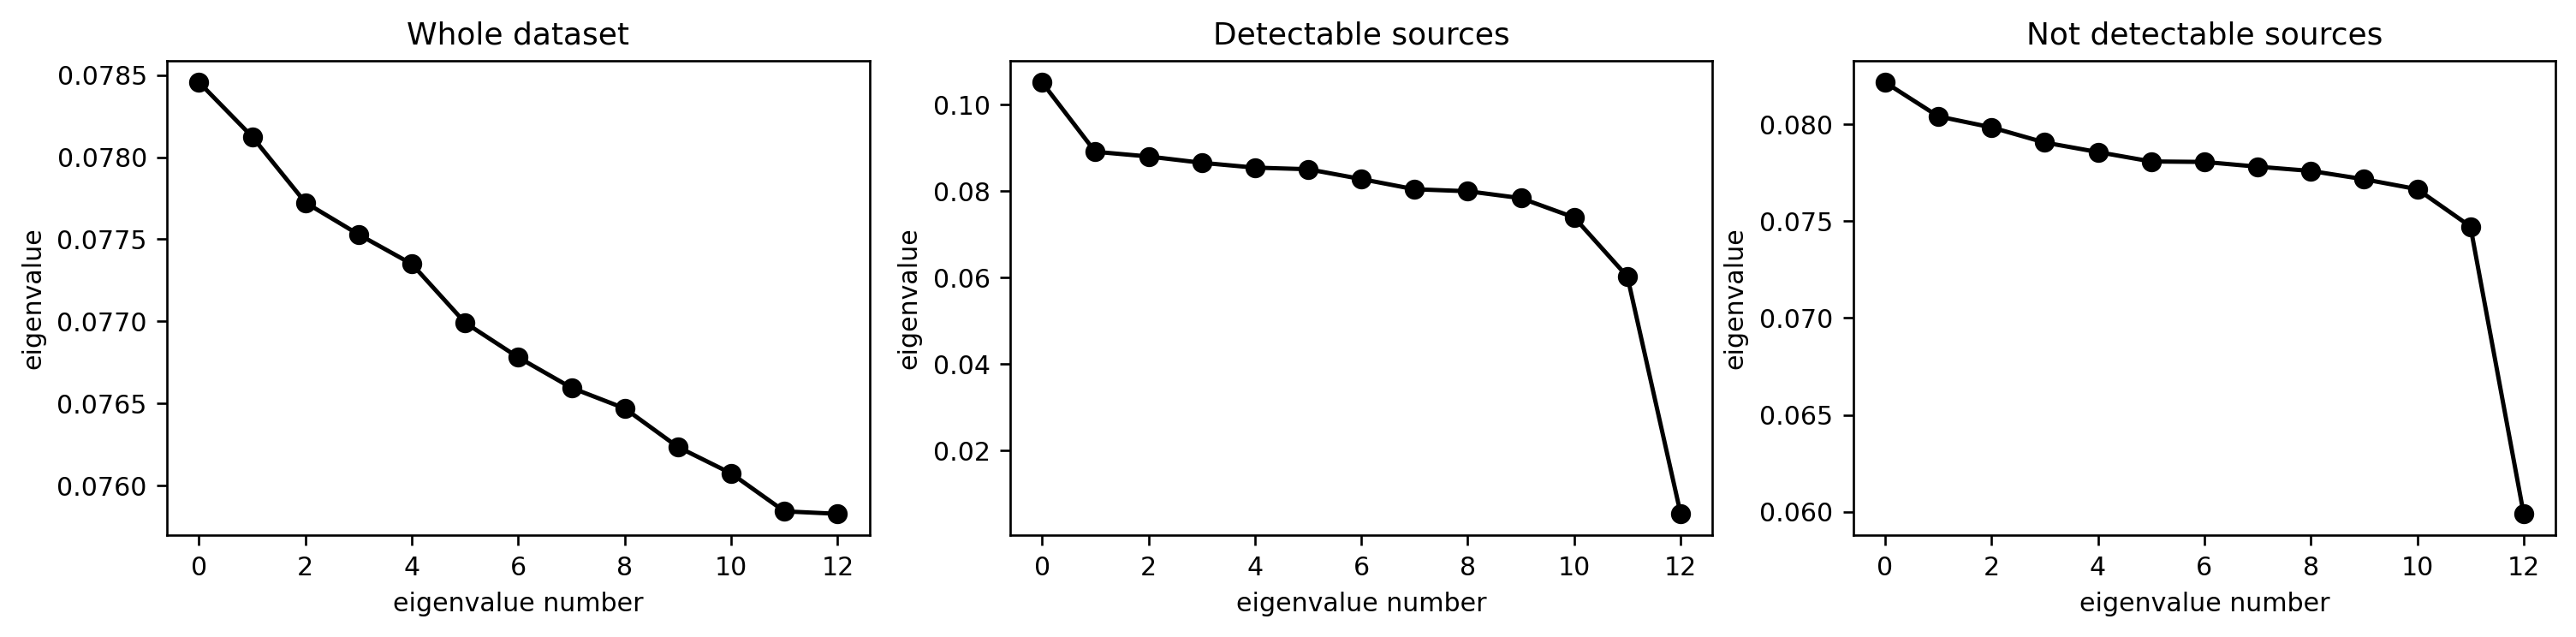

In [9]:
#-------  Plt params  ----------------
plt.rc('figure', figsize=(15,3), dpi=120)
plt.rcParams.update({'font.size': 9})
#--------------------------------------------

fig,ax = plt.subplots(1,3)

n_components = len(X[0,:])

pca = PCA(n_components = n_components, svd_solver='full')

pca.fit(X_train)
evals = pca.explained_variance_ratio_ 
ax[0].plot(np.arange(n_components), evals, '-ok')
ax[0].set_xlabel('eigenvalue number')
ax[0].set_ylabel('eigenvalue')
ax[0].set_title('Whole dataset')

pca.fit(X_train[y_train==1])
evals = pca.explained_variance_ratio_ 
ax[1].plot(np.arange(n_components), evals, '-ok')
ax[1].set_xlabel('eigenvalue number')
ax[1].set_ylabel('eigenvalue')
ax[1].set_title('Detectable sources')

pca.fit(X_train[y_train==0])
evals = pca.explained_variance_ratio_ 
ax[2].plot(np.arange(n_components), evals, '-ok')
ax[2].set_xlabel('eigenvalue number')
ax[2].set_ylabel('eigenvalue')
ax[2].set_title('Not detectable sources')

plt.tight_layout;

It seems PCA is not effective to reduce dimensionality: every PCA feature explains the same amount of variance.

---

## t-SNE

In [34]:
tsne = TSNE(n_components=2,learning_rate=200, n_jobs=-1)
X_reduced = tsne.fit_transform(X_train)

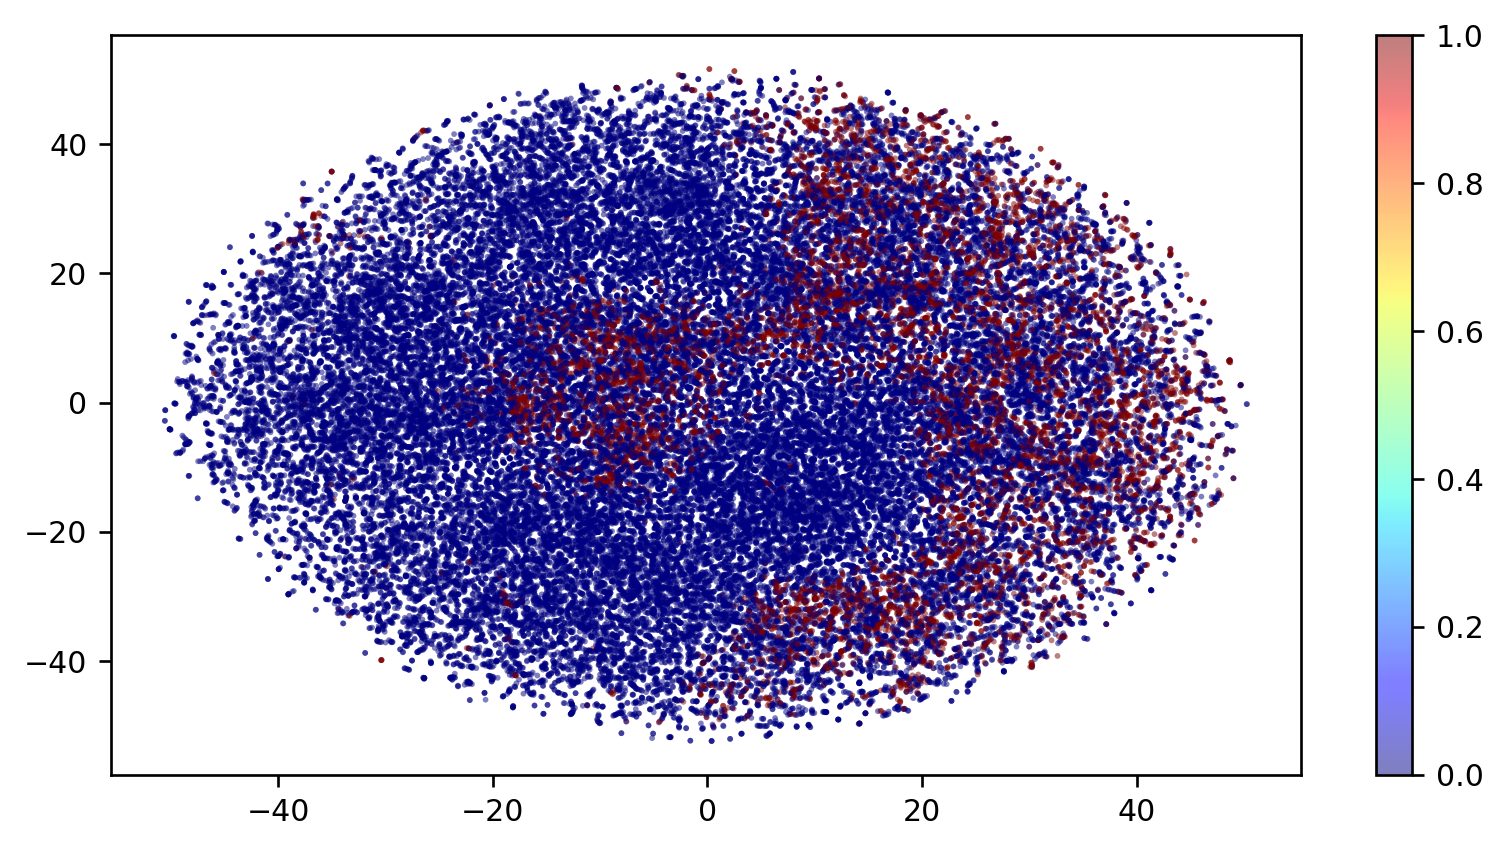

In [43]:
plt.scatter(X_reduced[:,0],X_reduced[:,1], 
            c=y_train, cmap='jet', alpha=0.5, 
            edgecolor="None", s=3)
plt.colorbar()

Not very separable: probably we could identify all quasars, but there would be a lot of contamination.

In [52]:
import h5py

hf = h5py.File('W20_tsne_data.h5', 'w')
hf.create_dataset('X_tne', data=X_reduced)

<HDF5 dataset "X_tne": shape (70000, 2), type "<f4">

In [53]:
hf.close()

---
## Feature importances
We train a Random Forest classifier and try evaluate the importance for classification of each feature

In [28]:
forest = RandomForestClassifier(n_jobs=-1)
forest.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1)

In [29]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

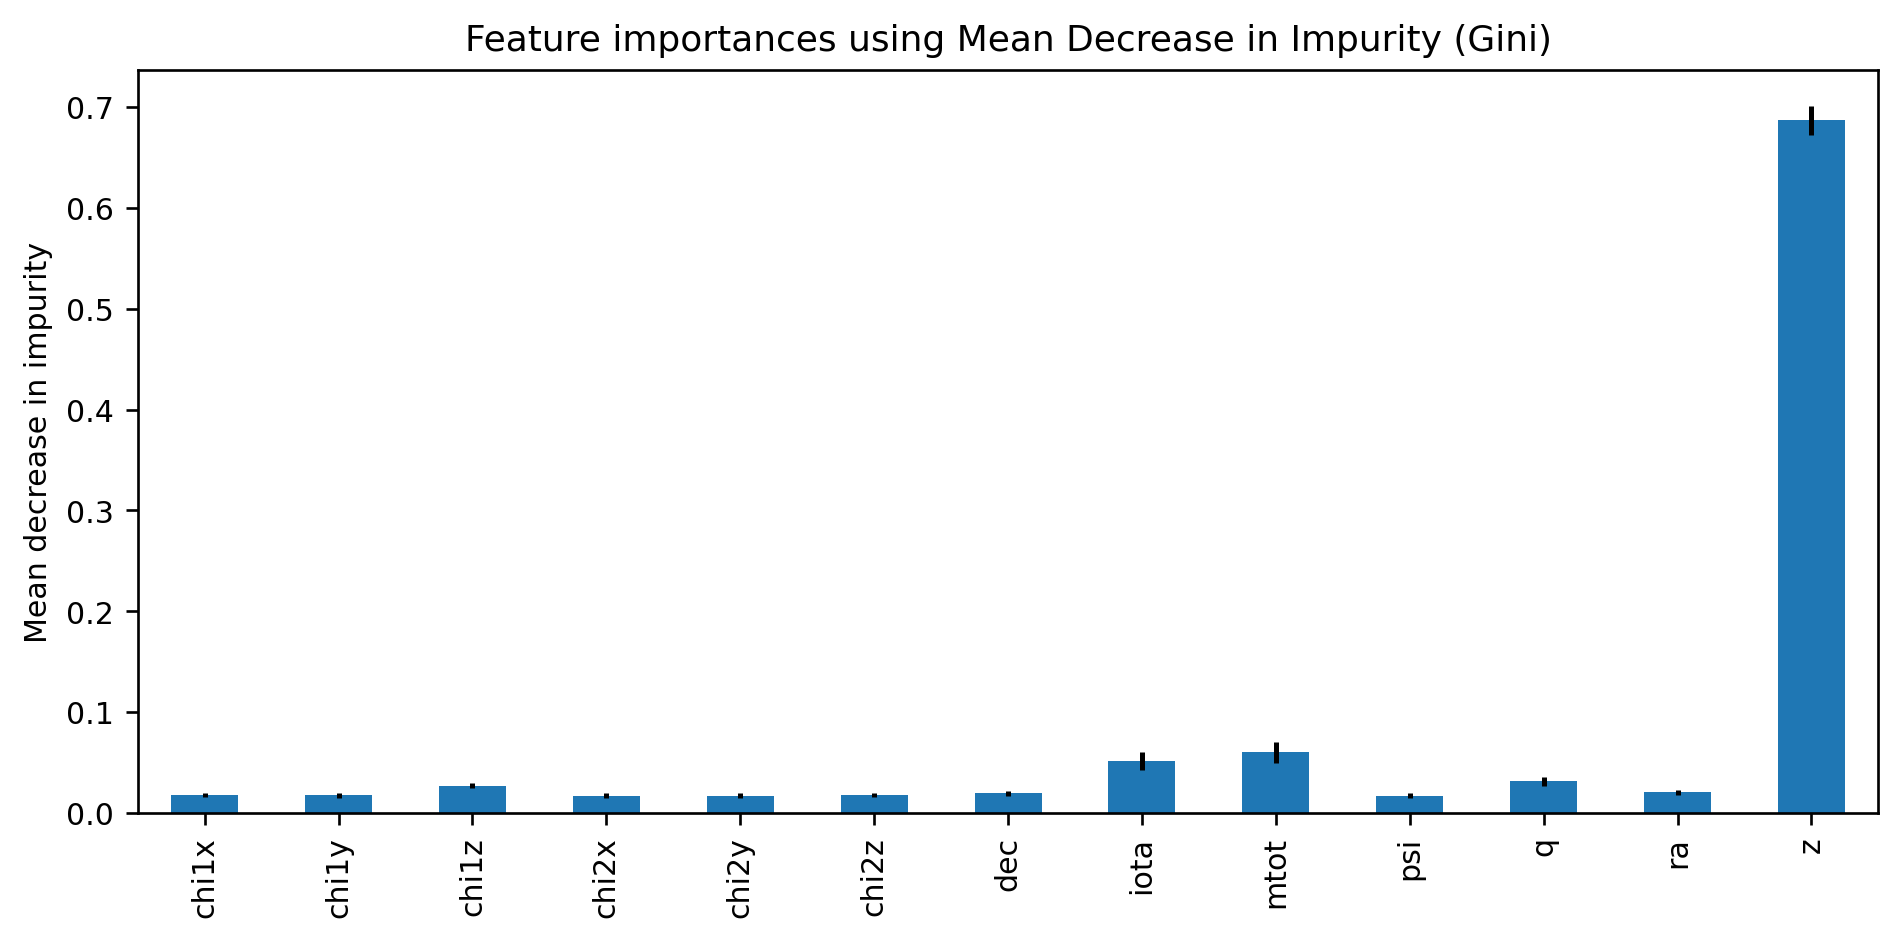

In [32]:
#-------  Plt params  ----------------
plt.rc('figure', figsize=(8,4), dpi=120)
plt.rcParams.update({'font.size': 9})
#--------------------------------------------

import pandas as pd

forest_importances = pd.Series(importances, index=keys)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using Mean Decrease in Impurity (Gini)")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

We actually see that a RandomForestClassifier bases its prediction for the most part on the features we selected.

---

## Classification


In [8]:
# USEFUL FUNCTIONS
###################################################

def run_classifier(clf, **kwargs):
    '''
    Trains and evaluates performance of a single classifier
        
    Input: clf(sklearn classifier object), name(str)
    Output: list of "info" containing a list of [metrics, curves], clf params, clf input name
    
    Kwargs: 
    
    proba = True, can be set to False if the classifier doeas not have predict_proba() method (like SVC).
    name = 'custom_name' , to use custom name.
    test_metrics = False , can be set to True to compute metrics on the test set.
    kfolds = 5, number of folds for CV for computing metrics using the train set
    '''
    # Setting default kwargs
    name = kwargs.get('name', str(clf) )
    proba = kwargs.get('proba', True )
    test_metrics = kwargs.get('test_metrics', False)
    kfolds = kwargs.get('kfolds', 5)
    
    print(f'Fitting {name}')

    clf.fit(X_train, y_train) # Fit classifier
    
    if proba == False:
        y_probs = clf.decision_function(X_test)
    else:
        y_probs = clf.predict_proba(X_test)[:, 1]
        
    y_pred = clf.predict(X_test)
    
    #-------------------------------------------------------------------------------
    if test_metrics == True:
        complet = recall_score(y_test, y_pred)
        contam = 1 - precision_score(y_test, y_pred)
        accur = accuracy_score(y_test, y_pred)
        sigmas = np.array([.0,.0, .0])
    else:
        score_list = ['accuracy', 'recall', 'precision' ]
        cv_results = cross_validate(clf, X_train, y_train, scoring = score_list, 
                                    n_jobs=-1, verbose=1, cv=kfolds )

        accur = np.mean(cv_results['test_accuracy'])
        accur_sigma = np.std(cv_results['test_accuracy'])
        complet = np.mean(cv_results['test_recall'])
        complet_sigma = np.std(cv_results['test_recall'])
        contam = np.mean(1 - cv_results['test_precision'])
        contam_sigma = np.std(1 - cv_results['test_precision'])
        
        sigmas = np.array([accur_sigma, complet_sigma, contam_sigma])
        
    #-------------------------------------------------------------------------------    
    
    metrics = np.array([accur, complet, contam])
    
    
    fpr, tpr, thresh = roc_curve(y_test, y_probs)
    precision, recall, thresh2 = precision_recall_curve(y_test, y_probs)
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    precision = np.concatenate([[0], precision])
    recall = np.concatenate([[1], recall])
    
    curves = [[fpr,tpr],[precision,recall]]
    
    results = [metrics, curves, sigmas]
    params = clf.get_params()
    
    info = [results, params, name]
    return  info

###################################################

def run_classifier_list (classifiers_list, **kwargs):
    '''
    DO NOT USE WITH SVC etc (without .predict_proba() method): use run_classifier() on the single clf and then append info manually
    
    Trains and evalutate performance of a list of classifiers
   
    Inputs: list of classifiers, listo of names
    Output: list of "info" lists from run_classifier() function
    
    kwargs:
    names = ['name1','name2',..] , to use custom name list for classifiers
    test_metrics =False , can be set to True to compute metrics on the test set
    kfolds = 5, number of folds for CV for computing metrics using the train set
    '''
    
    names = kwargs.get('names', [str(clf) for clf in classifiers_list] )
    test_metrics = kwargs.get('test_metrics',False)
    kfolds = kwargs.get('kfolds', 5)
    
    info_list = []
    for clf, name in zip(classifiers_list,names):
        info_list.append(run_classifier(clf, name=name, test_metrics=test_metrics, kfolds=kfolds ))
    return info_list

###################################################

def compare_classifiers(info_list, plot_curves = True, plot_metrics_bars = True, figtitle='none'):
    ''' 
    Compares performance of classifiers evaluated beforehand.
    
    Input: list of outputs from run_classifier()
    Output: metrics pd.DataFrame, list of params of the classifiers
    
    kwargs:
    figtitle = 'chosen title' , to set a chosen title for the two figures
    '''
    
    results_list = [info[0] for info in info_list]
    params_list = [info[1] for info in info_list]
    names = [info[2] for info in info_list]

    metrics_arr = np.array([results[0] for results in results_list]).T
    sigmas_arr = np.array([results[2] for results in results_list]).T
    keys = ['name', 'accuracy', 'completeness', 'contamination']
    metrics_d = dict(zip(keys,[names, *metrics_arr]))
    
    metrics_dataframe = pd.DataFrame(metrics_d).sort_values("accuracy", ascending=False)
    display(metrics_dataframe)
    
    if plot_curves == True:
        
        #-------  Plt params  ----------------
        plt.rc('figure', figsize=(9, 4.5), dpi=120)
        plt.rcParams.update({'font.size': 9})         
        #--------------------------------------------
        
        # fig = plt.figure()
        fig, axs = plt.subplots(1,2)
        
        if figtitle != 'none':
            fig.suptitle(figtitle, fontsize=16)
        
        ax1 = axs[0]
        ax2 = axs[1]
        
        # fig.subplots_adjust(hspace=0.5, wspace=0.5)

        for results,name  in zip(results_list,names):
            curves = results[1]
            roc = curves[0]
            prec_rec = curves[1]
            ax1.plot(roc[0],roc[1], label=name)
            ax2.plot(prec_rec[0], prec_rec[1], label=name)
            
        ax1.set_xlabel('false positive rate')
        ax1.set_ylabel('true positive rate')
        ax1.set_title('ROC curves')
        ax1.legend(loc=4)
        ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2))        
        ax1.set_xlim(0, 1.0)
        ax1.set_ylim(0.9, 1.01)
        ax2.set_xlabel('precision')
        ax2.set_ylabel('recall')
        ax2.set_title('Precision - Recall curves')
        ax2.set_xlim(0, 1.0)
        ax2.set_ylim(0.9, 1.01);
        
        
    if plot_metrics_bars == True:
        #-------  Plt params  ----------------
        plt.rc('figure', figsize=(10,5), dpi=120)
        plt.rcParams.update({'font.size': 10})
        #--------------------------------------------

        fig, axs = plt.subplots(1,3)
        fig.subplots_adjust(hspace=0.05, wspace=0.05)
        
        if figtitle != 'none':
            fig.suptitle(figtitle, fontsize=16)
        
        margins = [0.0005,0.005,0.0005]
        x=1
        labels = ['Accuracy', 'Completeness', 'Contamination']
        width = 1  # the width of the bars
        
        for i,(ax, label) in enumerate(zip(axs.flatten(),labels)):
            j=0
            for name, metrics, sigmas in zip(names, metrics_arr.T, sigmas_arr.T):
                rect = ax.bar(x+width*j, metrics[i], width, label=name)
                ax.errorbar(x+width*j, metrics[i], yerr=sigmas[i],  fmt='.k', ecolor='gray', lw=1, capsize = 2, markersize=5)         
                ax.bar_label(rect, padding=3, fmt='%.4f', fontsize=8)
                j+=1
            ax.set_title(label)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_ylim(np.min(metrics_arr[i]-sigmas_arr[i]) - margins[i], np.max(metrics_arr[i]  + sigmas_arr[i]) + margins[i]) 
        axs[0].set_ylabel('Scores')
            
            # Legend next to graph
            # ax.legend(loc='upper center', bbox_to_anchor=(1.25, 1)) 
        
            # Put a vertical legend below current axis
        axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05))
            
            # Put a horizontal legend below current axis
            # ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=5)
            
        # fig.tight_layout()
            

    return metrics_dataframe, params_list

###################################################

In [10]:
clf_svc = SVC()

clf_dtc = DecisionTreeClassifier()
clf_rdf = RandomForestClassifier(n_jobs=-1)
clf_bag = BaggingClassifier(n_jobs=-1) 
clf_ada = AdaBoostClassifier()

clf_list = [clf_dtc, clf_rdf, clf_bag, clf_ada]



In [ ]:
info_list1 = run_classifier_list(clf_list, test_metrics=False, kfolds=10)

In [12]:
svc_info_list = []
    
info = run_classifier(clf_svc, proba = False, test_metrics=False, kfolds=10)
svc_info_list.append(info)

Fitting SVC()


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  1.3min remaining:   53.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.8min finished


In [13]:
info_list_tot = info_list1 + svc_info_list

name  accuracy  completeness  contamination
4                              SVC()  0.966614      0.876419       0.110824
1  RandomForestClassifier(n_jobs=-1)  0.965700      0.846522       0.092019
2       BaggingClassifier(n_jobs=-1)  0.962529      0.829777       0.099009
3               AdaBoostClassifier()  0.962029      0.840144       0.111045
0           DecisionTreeClassifier()  0.948671      0.820909       0.178934

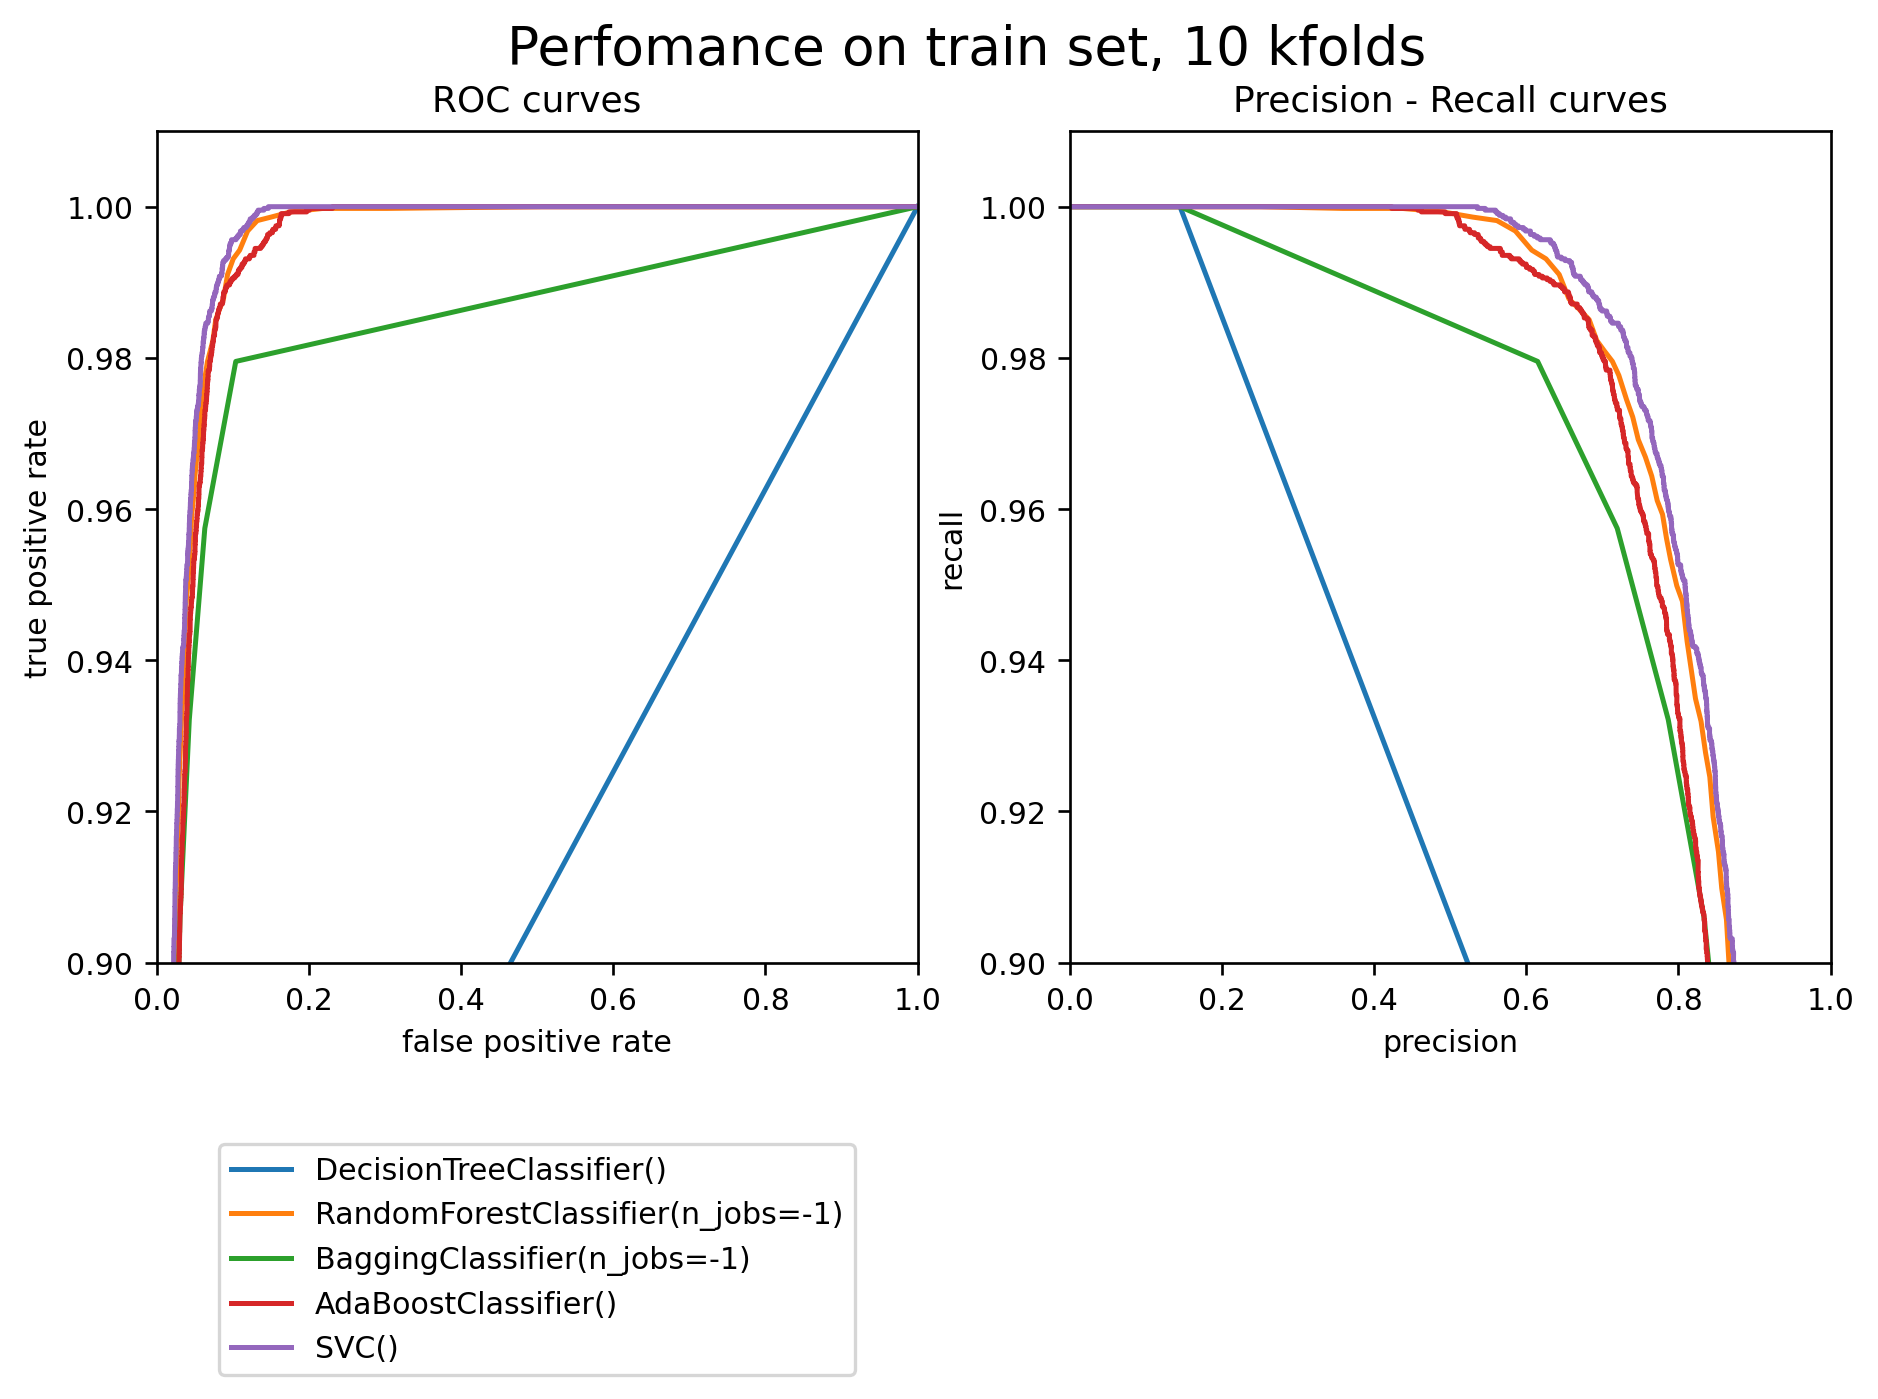

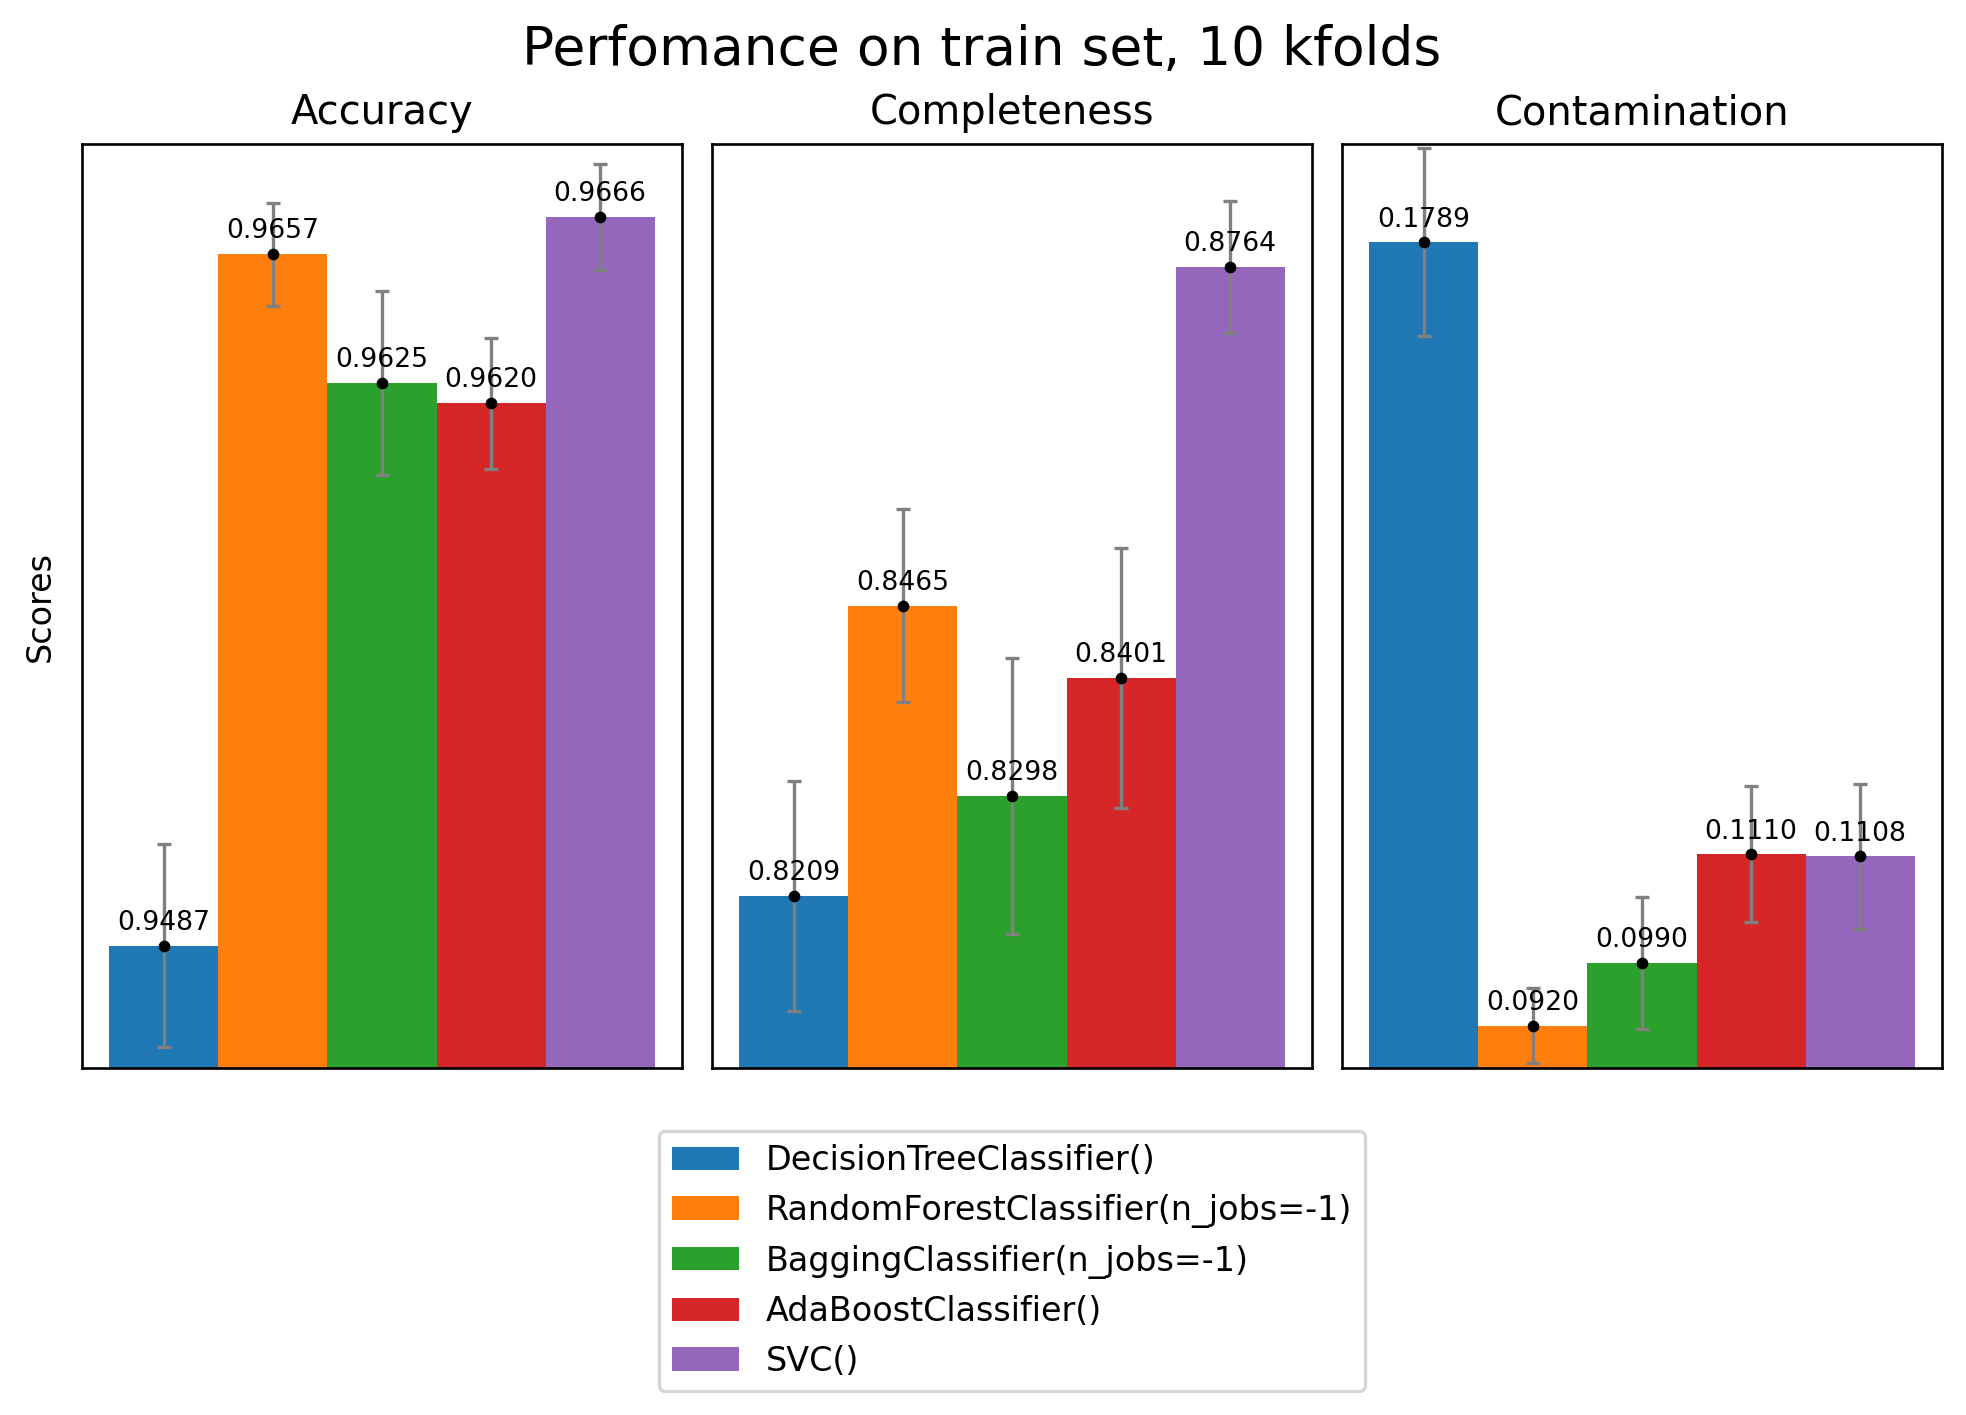

In [14]:
# Change colormap

# cmap=plt.cm.Blues_r
# c = cycler('color', cmap(np.linspace(0,0.5,len(info_list1))) )
# plt.rcParams["axes.prop_cycle"] = c

cmap=plt.cm.tab10
c = cycler('color', cmap(range(10)))
plt.rcParams["axes.prop_cycle"] = c

a1 = compare_classifiers(info_list_tot, figtitle='Perfomance on train set, 10 kfolds')

Best overall classifier is SVC, support vector machine with rbf kernel.

## Reduced dataset

In [43]:
# USEFUL FUNCTIONS FOR REDUCED DATASET
###################################################

def Z_run_classifier(clf, **kwargs):
    '''
    Trains and evaluates performance of a single classifier
    Use kwarg name = 'custom_name' to use custom name
    Use kwarg proba = False if using a SVC - like classifier (which does not have .predict_proba() method)
    
    Input: clf(sklearn classifier object), name(str)
    Output: list of "info" containing a list of [metrics, curves], clf params, clf input name
    '''
    name = kwargs.get('name', str(clf) )
    proba = kwargs.get('proba', True )
    
    print(f'Fitting {name}')

    clf.fit(Z_train, yz_train)
    
    if proba == False:
        y_probs = clf.decision_function(Z_test)
    else:
        y_probs = clf.predict_proba(Z_test)[:, 1]
        
    y_pred = clf.predict(Z_test)
    
    complet = recall_score(yz_test, y_pred)
    contam = 1 - precision_score(yz_test, y_pred)
    accur = accuracy_score(yz_test, y_pred)
    
    metrics = np.array([accur, complet, contam])
    
    fpr, tpr, thresh = roc_curve(yz_test, y_probs)
    precision, recall, thresh2 = precision_recall_curve(yz_test, y_probs)
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    precision = np.concatenate([[0], precision])
    recall = np.concatenate([[1], recall])
    
    curves = [[fpr,tpr],[precision,recall]]
    
    results = [metrics, curves]
    params = clf.get_params()
    
    info = [results, params, name]
    return  info

###################################################

def Z_run_classifier_list (classifiers_list, **kwargs):
    '''
    Trains and evalutate performance of a list of classifiers
    Use kwarg names= ['name1','name2',..] to use custom name list for classifiers
    
    Inputs: list of classifiers, listo of names
    Output: list of "info" lists from run_classifier() function'''
    
    names = kwargs.get('names', [str(clf) for clf in classifiers_list] )
    
    info_list = []
    for clf, name in zip(classifiers_list,names):
        info_list.append(Z_run_classifier(clf, name=name))
    return info_list

###################################################

def compare_classifiers(info_list, plot_curves = True, plot_metrics_bars = True):
    ''' 
    Compares performance of classifiers evaluated beforehand.
    
    Input: list of outputs from run_classifier()
    Output: metrics pd.DataFrame, list of params of the classifiers
    '''
    results_list = [info[0] for info in info_list]
    params_list = [info[1] for info in info_list]
    names = [info[2] for info in info_list]

    metrics_arr = np.array([results[0] for results in results_list]).T
    keys = ['name', 'accuracy', 'completeness', 'contamination']
    metrics_d = dict(zip(keys,[names, *metrics_arr]))
    
    metrics_dataframe = pd.DataFrame(metrics_d).sort_values("accuracy", ascending=False)
    display(metrics_dataframe)
    
    if plot_curves == True:
        
        #-------  Plt params  ----------------
        plt.rc('figure', figsize=(9,3), dpi=120)
        plt.rcParams.update({'font.size': 9})         
        #--------------------------------------------
        
        fig = plt.figure()
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)

        for results,name  in zip(results_list,names):
            curves = results[1]
            roc = curves[0]
            prec_rec = curves[1]
            ax1.plot(roc[0],roc[1], label=name)
            ax2.plot(prec_rec[0], prec_rec[1], label=name)
            
        ax1.set_xlabel('false positive rate')
        ax1.set_ylabel('true positive rate')
        ax1.set_title('ROC curves')
        ax1.legend(loc=4)
        ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2))        
        ax1.set_xlim(0, 1.0)
        ax1.set_ylim(0, 1.01)
        ax2.set_xlabel('precision')
        ax2.set_ylabel('recall')
        ax2.set_title('Precision - Recall curves')
        ax2.set_xlim(0, 1.0)
        ax2.set_ylim(0, 1.01);
        
        
    if plot_metrics_bars == True:
        #-------  Plt params  ----------------
        plt.rc('figure', figsize=(11,5), dpi=120)
        plt.rcParams.update({'font.size': 10})
        #--------------------------------------------

        fig, axs = plt.subplots(1,3)
        fig.subplots_adjust(hspace=0.05, wspace=0.05)
        
        
        margins = [0.01,0.01,0.01]
        x=1
        labels = ['Accuracy', 'Completeness', 'Contamination']
        width = 1  # the width of the bars
        
        for i,(ax, label) in enumerate(zip(axs.flatten(),labels)):
            j=0
            for name, metrics in zip(names, metrics_arr.T):
                rect = ax.bar(x+width*j, metrics[i], width, label=name)         
                ax.bar_label(rect, padding=3, fmt='%.4f', fontsize=8)
                j+=1
            ax.set_title(label)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_ylim(np.min(metrics_arr[i]) - margins[i], np.max(metrics_arr[i] + margins[i] )) 
        axs[0].set_ylabel('Scores')
            
            # Legend next to graph
            # ax.legend(loc='upper center', bbox_to_anchor=(1.25, 1)) 
        
            # Put a vertical legend below current axis
        axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05))
            
            # Put a horizontal legend below current axis
            # ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=5)
            
        # fig.tight_layout()
            

    return metrics_dataframe, params_list

###################################################

if False:
# To do everything in one go
    def evaluate_classifiers(clf_list, names, plot_curves = True, plot_metrics_bars = True): 
        '''
        Trains and compares different classifiers.
        
        Input: List of classifiers, list of names
        Output: metrics pd.DataFrame and list of classifier params
        If plot = True (default) plots ROC and precision-recall curves
        '''
        info_list = []
        
        for clf,name in zip(clf_list,names): # Run classifiers using above funciton
            info = run_classifier(clf,name)
            info_list.append(info)
            
        metrics_dataframe, params_list = compare_classifiers(info_list, plot_curves, plot_metrics_bars)
                    
        return metrics_dataframe, params_list


In [13]:
clf_svc_rbf = SVC(kernel='rbf')
clf_svc_poly = SVC(kernel='poly')
clf_dtc = DecisionTreeClassifier()
clf_rdf = RandomForestClassifier()
clf_bag = BaggingClassifier(n_jobs=-1) 
clf_ada = AdaBoostClassifier()

classifiers = [clf_svc_rbf, clf_svc_poly, clf_dtc, clf_rdf,clf_bag,clf_ada]


In [15]:
info_list_z = Z_run_classifier_list(classifiers)

Fitting SVC()
Fitting SVC(kernel='poly')
Fitting DecisionTreeClassifier()
Fitting RandomForestClassifier()
Fitting BaggingClassifier(n_jobs=-1)
Fitting AdaBoostClassifier()


name  accuracy  completeness  contamination
0                         SVC()  0.964433      0.857936       0.108868
3      RandomForestClassifier()  0.962800      0.841971       0.106336
5          AdaBoostClassifier()  0.960300      0.830403       0.113170
1            SVC(kernel='poly')  0.959867      0.823693       0.110445
4  BaggingClassifier(n_jobs=-1)  0.959700      0.821379       0.109606
2      DecisionTreeClassifier()  0.947800      0.810736       0.175917

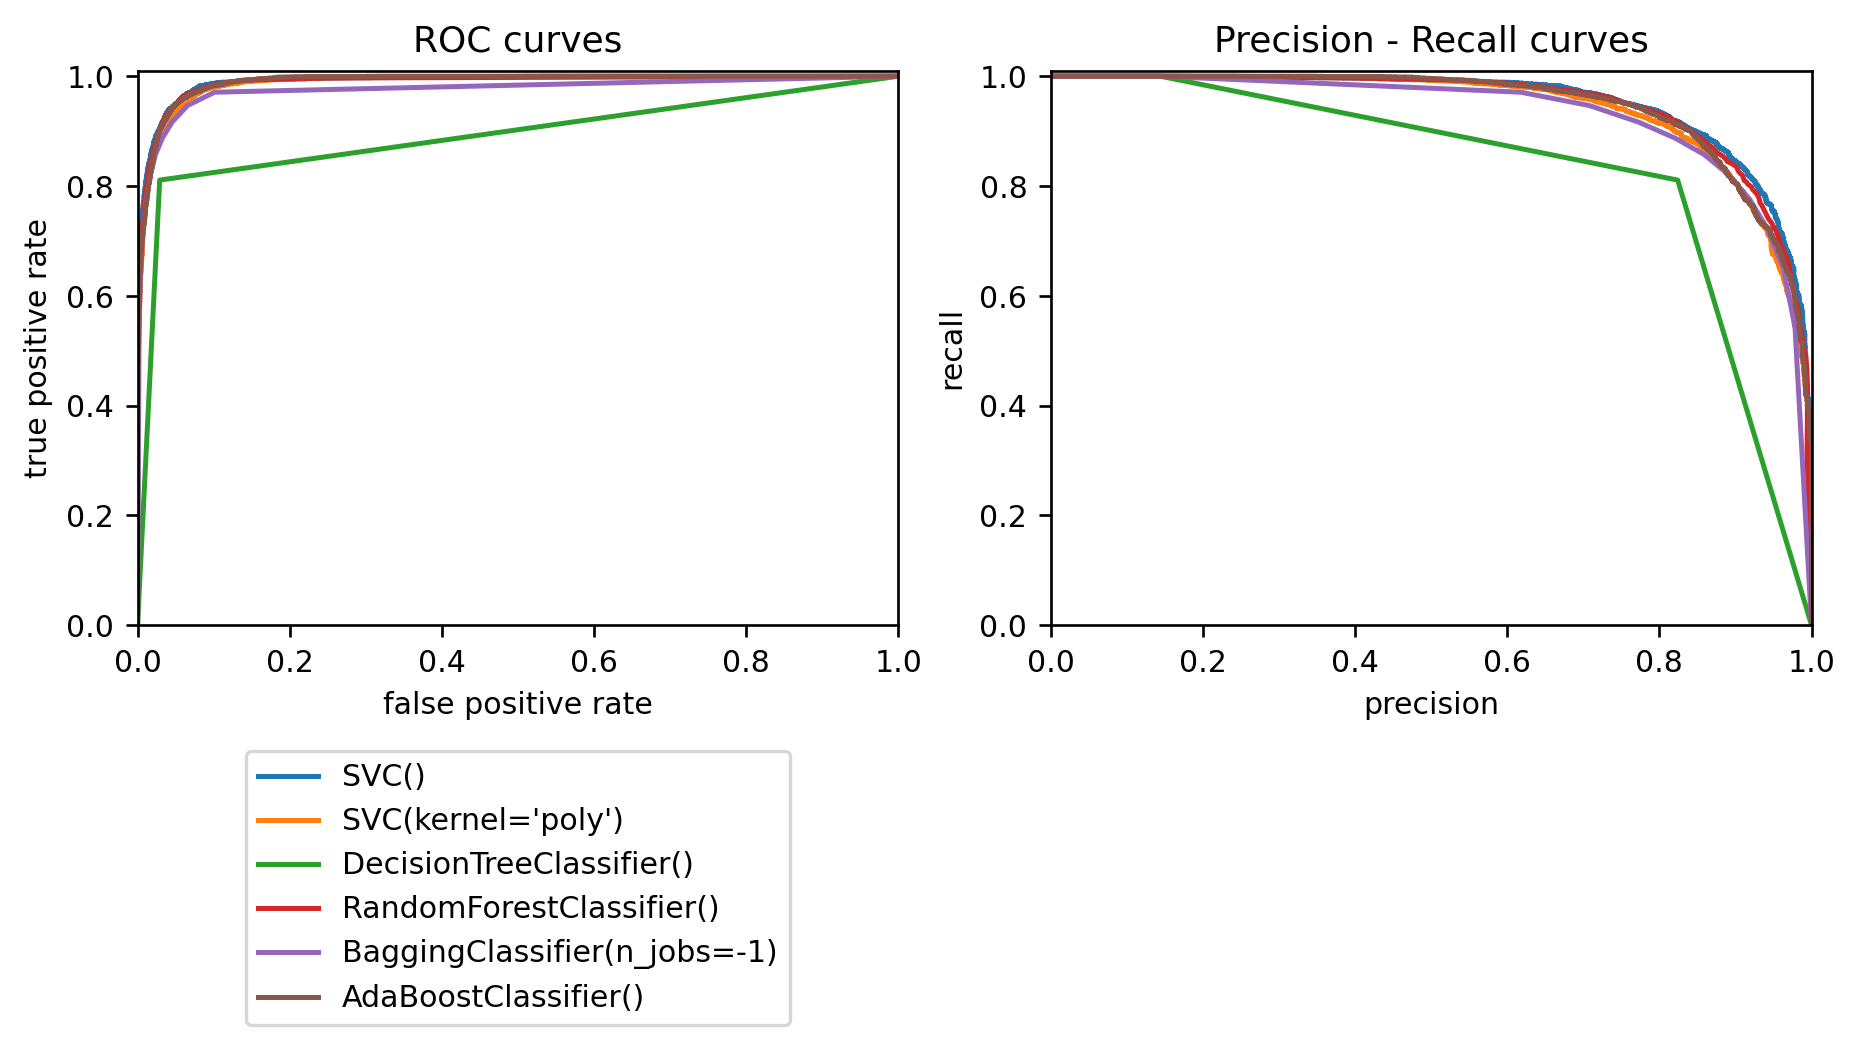

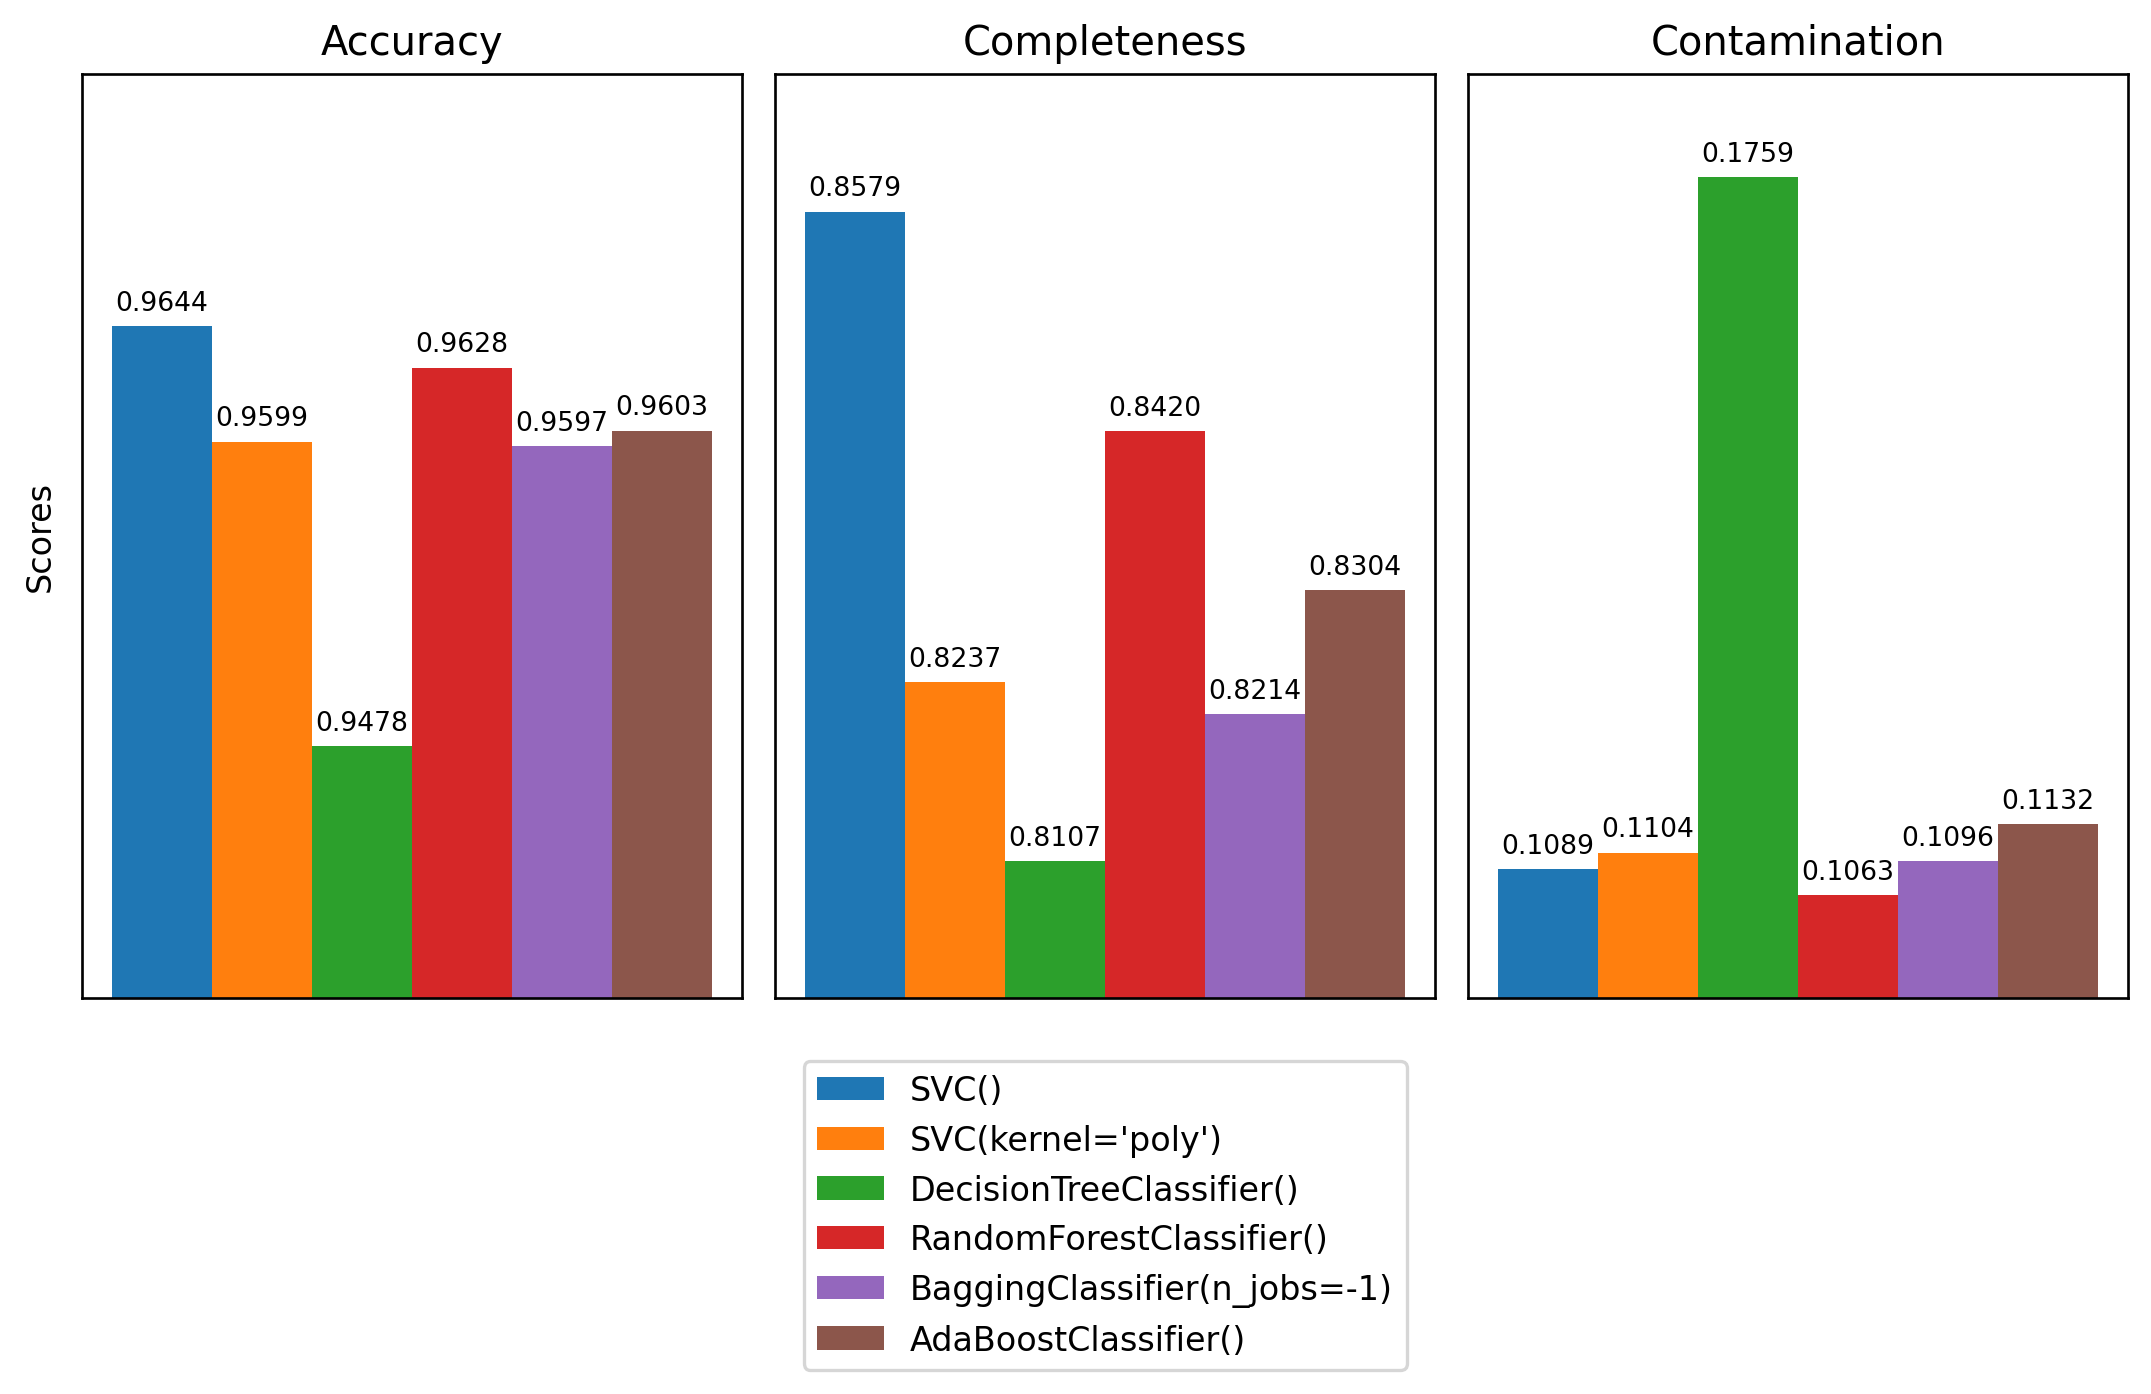

In [16]:
# Change colormap

# cmap=plt.cm.Blues_r
# c = cycler('color', cmap(np.linspace(0,0.5,len(info_list1))) )
# plt.rcParams["axes.prop_cycle"] = c

cmap=plt.cm.tab10
c = cycler('color', cmap(range(10)))
plt.rcParams["axes.prop_cycle"] = c

a_z = compare_classifiers(info_list_z )

No true improvement nor worsening from using the reduced dataset: means that these are actually the most informative features.

## Cross Validation for classifiers


In [18]:
# Use reduced number of points for CV, then evaluate with full set

Xcv=[]
keys = ['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec', 'iota', 'mtot', 'psi', 'q', 'ra','z'] 

number_of_points = int(5e4) 

for key  in keys:
    Xcv.append(data[key][:number_of_points])
    
Xcv = np.array(Xcv).T
ycv = np.array(data['det'][:number_of_points])

# Scale data after splitting to avoid information leakage

Xcv_train, Xcv_test, ycv_train, ycv_test = train_test_split(Xcv, ycv, test_size=0.3, random_state=42)

scaler_cv = StandardScaler()

Xcv_train = scaler_cv.fit_transform(Xcv_train)
Xcv_test = scaler_cv.transform(Xcv_test)



### SVC Classifier

In [37]:
# GridSearchCV for SVC, hyperparameters found by adjusting parameter grid manually

#              C = For larger values of C, a smaller margin will be accepted if the decision function is better at classifying all training points correctly. 
#                     A lower C will encourage a larger margin, therefore a simpler decision function, at the cost of training accuracy
#  gamma = Intuitively, the gamma parameter defines how far the influence of a single training example reaches, with low values 
#                     meaning ‘far’ and high values meaning ‘close’.

clf_svc_rbf = SVC(kernel='rbf', cache_size=2000 )
d_svc_rbf = {'C': np.logspace(-1, 3 , 10), 'gamma': np.logspace(-4, 0, 10)} 

grid = GridSearchCV(clf_svc_rbf, d_svc_rbf, n_jobs=-1, cv=5, verbose=1)
grid.fit(Xcv_train,ycv_train)
print(grid.best_estimator_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   54.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.1min finished


SVC(C=359.38136638046257, cache_size=2000, gamma=0.005994842503189409)


Best parameters from cross-validation: C = 360, gamma = 0.006

In [28]:
base_svc = SVC()
best_svc = SVC(C=360, gamma=0.006)

### DecisionTreeClassifier

In [22]:
clf_dct = DecisionTreeClassifier()
d_dct = {'criterion':['gini', 'entropy'], 'max_depth': np.arange(4,20, 1)} 

grid = GridSearchCV(clf_dct, d_dct, n_jobs=-1, cv=10, verbose=1)
grid.fit(Xcv_train,ycv_train)
print(grid.best_params_)


Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:   27.3s finished


{'criterion': 'gini', 'max_depth': 7}


Best parameters from cross-validation: Criterion = gini, Max_depth = 7

In [25]:
base_tree = DecisionTreeClassifier()
best_tree = DecisionTreeClassifier(criterion='gini', max_depth= 7)

### RandomForest classifier

In [21]:
clf_rdf = RandomForestClassifier(n_jobs=-1)
d_rdf = {'n_estimators': np.arange(50,100,10), 'max_depth': np.arange(5,100,10)}

grid = GridSearchCV(clf_rdf, d_rdf, n_jobs=-1, cv=5, verbose=1)
grid.fit(Xcv_train,ycv_train)
print(grid.best_estimator_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  5.5min finished


RandomForestClassifier(max_depth=75, n_estimators=70, n_jobs=-1)


Best parameters from cross-validation: max_depth=75, n_estimators=70

In [26]:
base_forest = RandomForestClassifier(n_jobs=-1)
best_forest = RandomForestClassifier(n_jobs=-1, max_depth=75, n_estimators = 70)

In [29]:
# List of classifiers to be evaluated

class_list = [base_tree, best_tree, base_forest, best_forest]
svc_list = [base_svc, best_svc]

### Performance on train set

In [ ]:
info_list_best = run_classifier_list(class_list, test_metrics=False, kfolds=10)

In [ ]:
svc_info_list = []

for svc in svc_list:
    info = run_classifier(svc, proba = False, test_metrics=False, kfolds=10)
    svc_info_list.append(info)

In [34]:
info_list_tot = info_list_best + svc_info_list

name  accuracy  completeness  \
4                                              SVC()  0.966614      0.876419   
5                            SVC(C=360, gamma=0.006)  0.966229      0.875622   
2                  RandomForestClassifier(n_jobs=-1)  0.965371      0.844927   
3  RandomForestClassifier(max_depth=75, n_estimat...  0.964714      0.841041   
1                DecisionTreeClassifier(max_depth=7)  0.956843      0.851206   
0                           DecisionTreeClassifier()  0.948371      0.819912   

   contamination  
4       0.110824  
5       0.112641  
2       0.092817  
3       0.093833  
1       0.151737  
0       0.180036

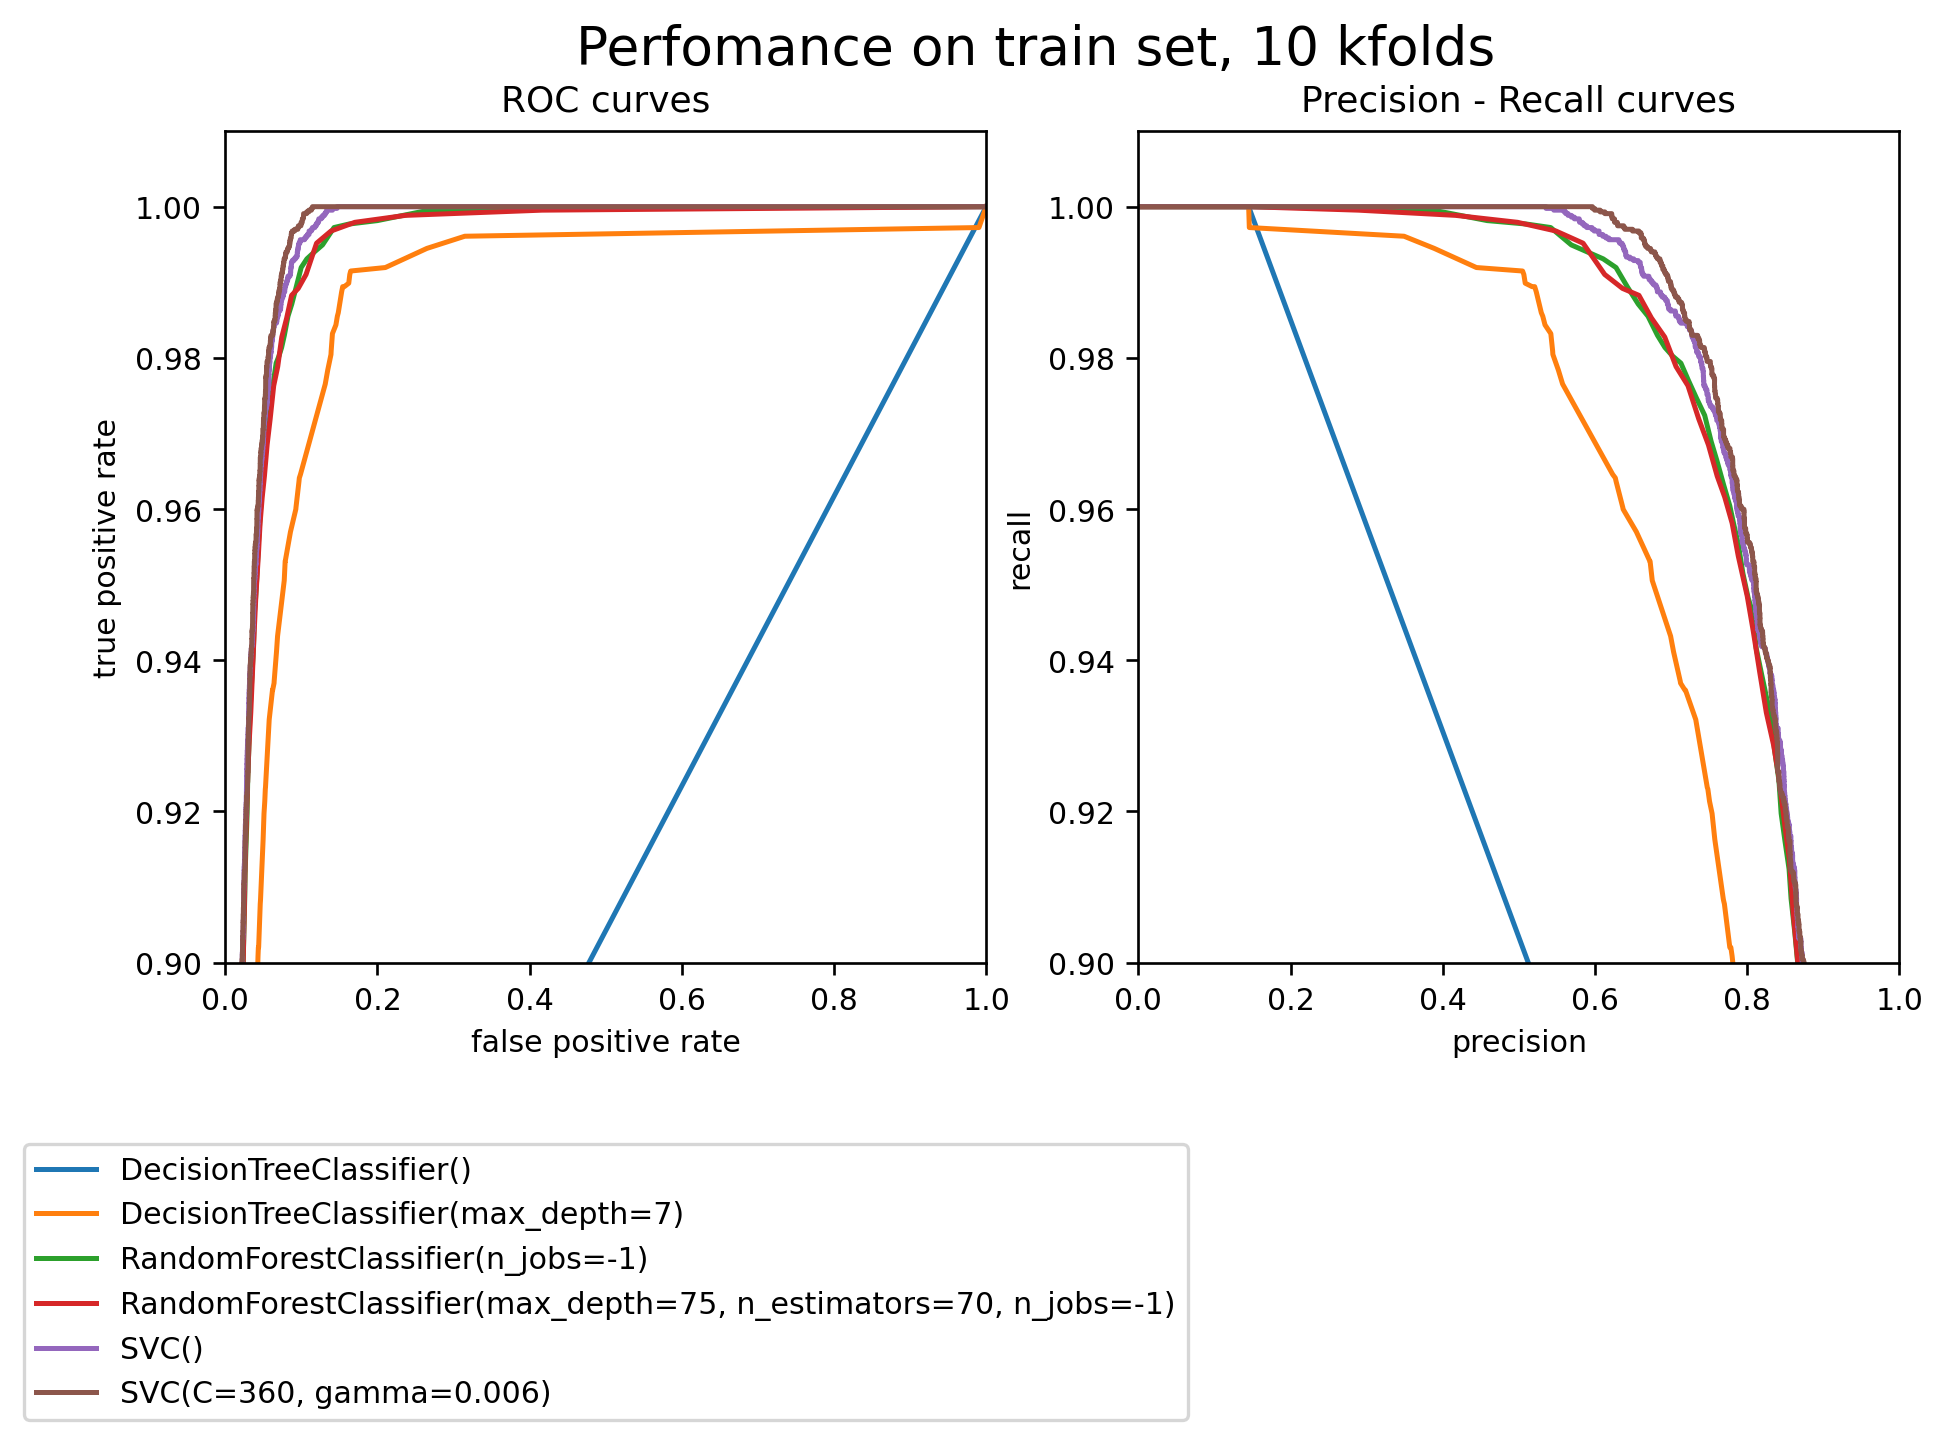

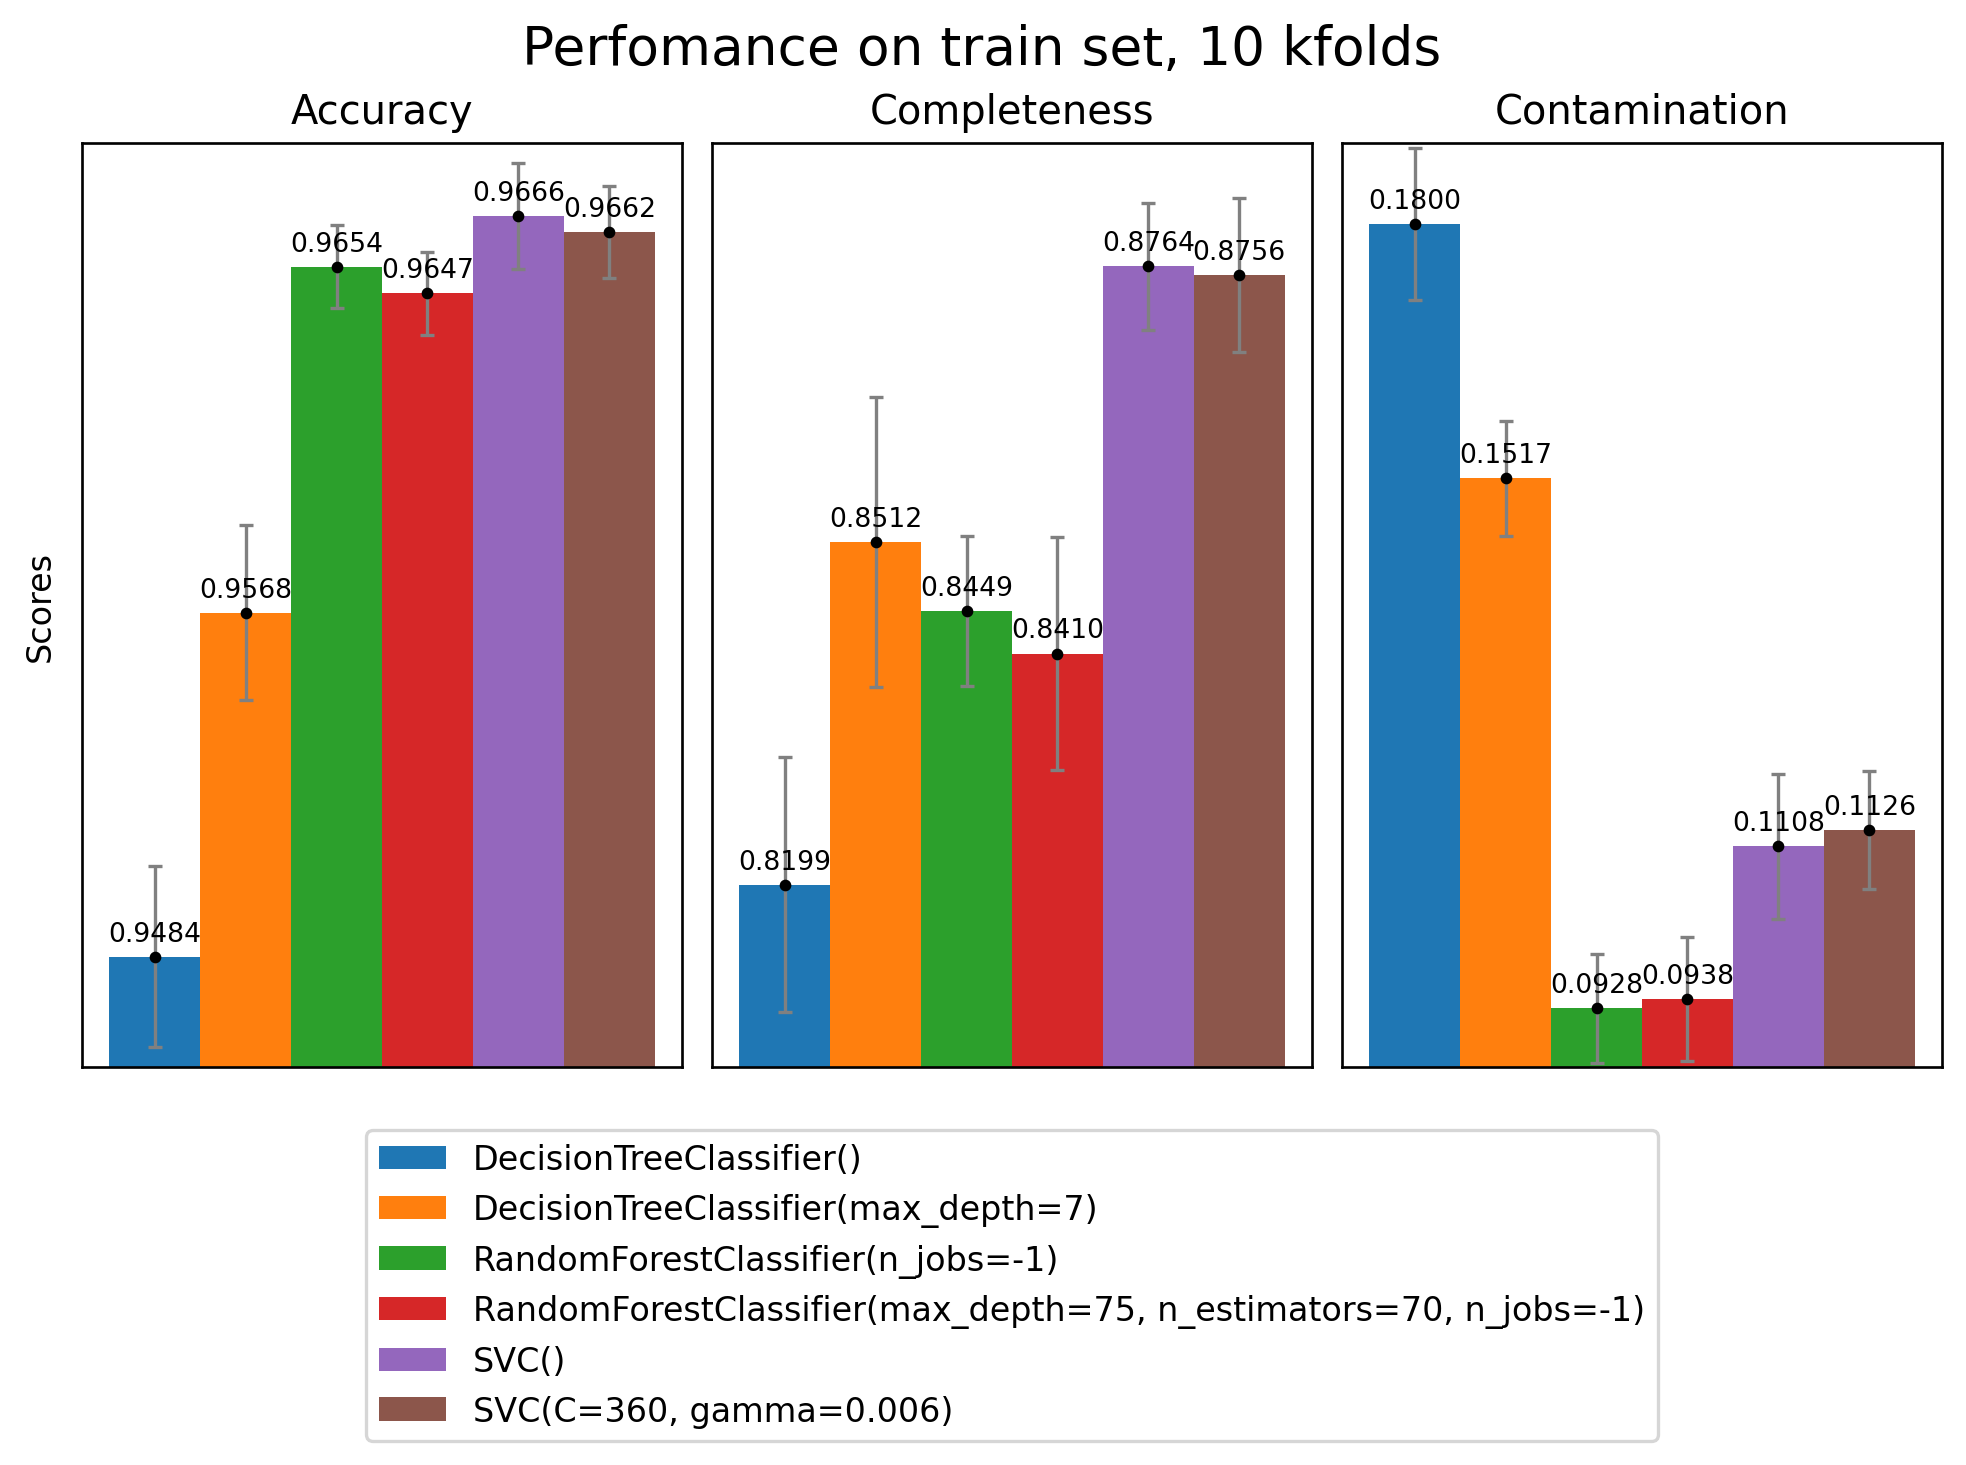

In [35]:
# Change colormap

# cmap=plt.cm.Blues_r
# c = cycler('color', cmap(np.linspace(0,0.5,len(info_list1))) )
# plt.rcParams["axes.prop_cycle"] = c

cmap=plt.cm.tab10
c = cycler('color', cmap(range(10)))
plt.rcParams["axes.prop_cycle"] = c

a1 = compare_classifiers(info_list_tot, figtitle='Perfomance on train set, 10 kfolds')

It seems CV did not actually improve performance on the train set except for the DecisionTree. 

### Performance on test set

In [ ]:
info_list_best_t = run_classifier_list(class_list, test_metrics=True)

In [ ]:
svc_info_list_t = []

for svc in svc_list:
    info = run_classifier(svc, proba = False, test_metrics=True)
    svc_info_list_t.append(info)

In [38]:
info_list_tot_t = info_list_best_t + svc_info_list_t

name  accuracy  completeness  \
5                            SVC(C=360, gamma=0.006)  0.966667      0.875345   
4                                              SVC()  0.966400      0.873735   
3  RandomForestClassifier(max_depth=75, n_estimat...  0.965067      0.843376   
2                  RandomForestClassifier(n_jobs=-1)  0.964133      0.837397   
1                DecisionTreeClassifier(max_depth=7)  0.954433      0.840616   
0                           DecisionTreeClassifier()  0.948533      0.817617   

   contamination  
5       0.107411  
4       0.107797  
3       0.090977  
2       0.092020  
1       0.155694  
0       0.174408

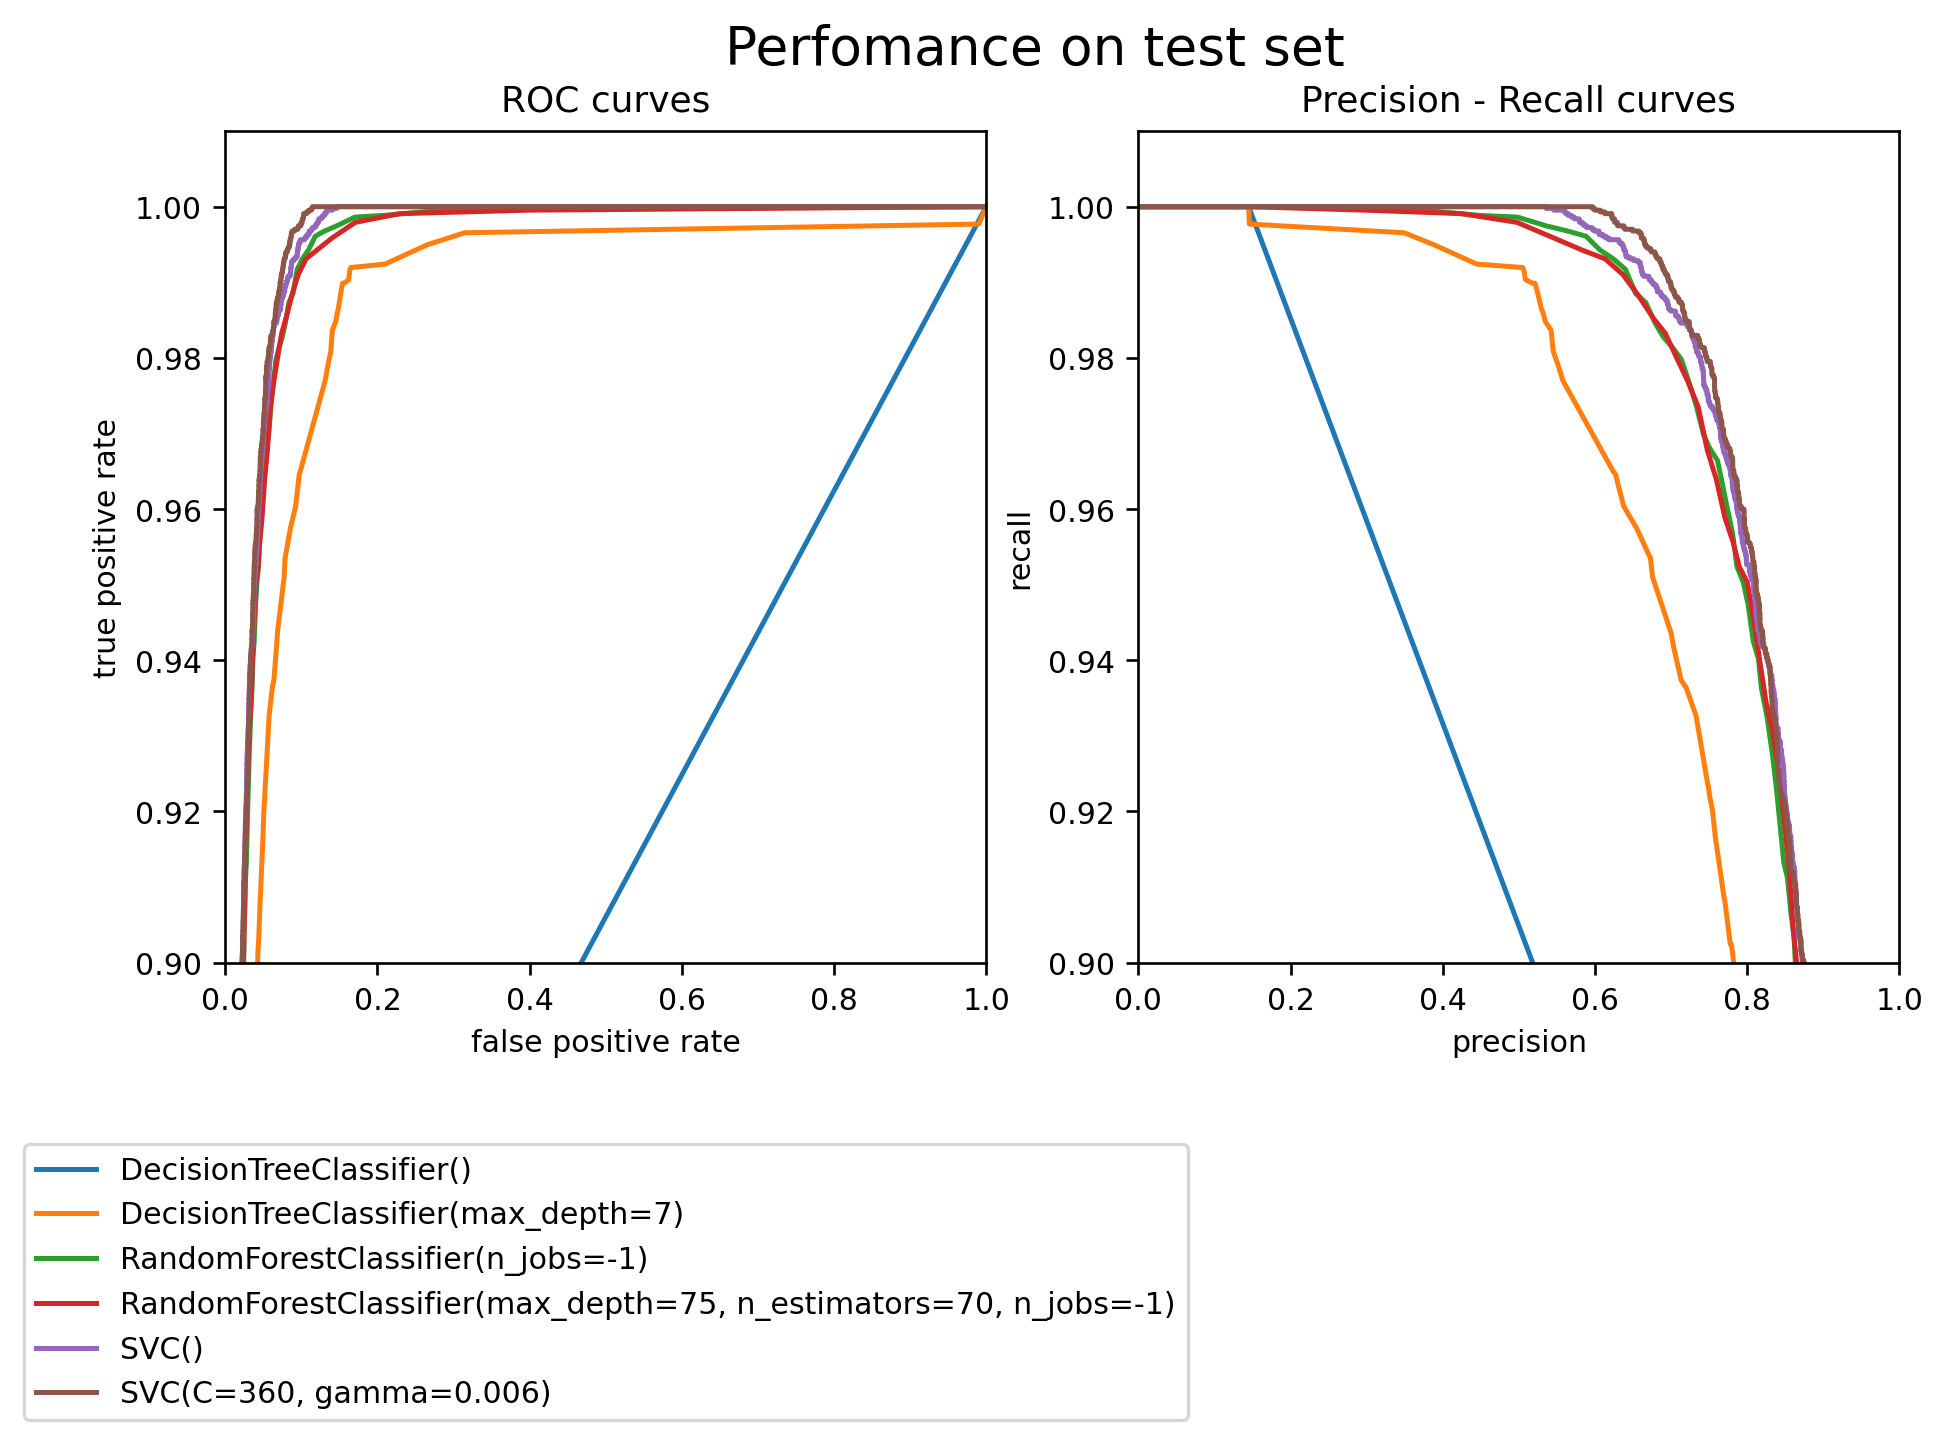

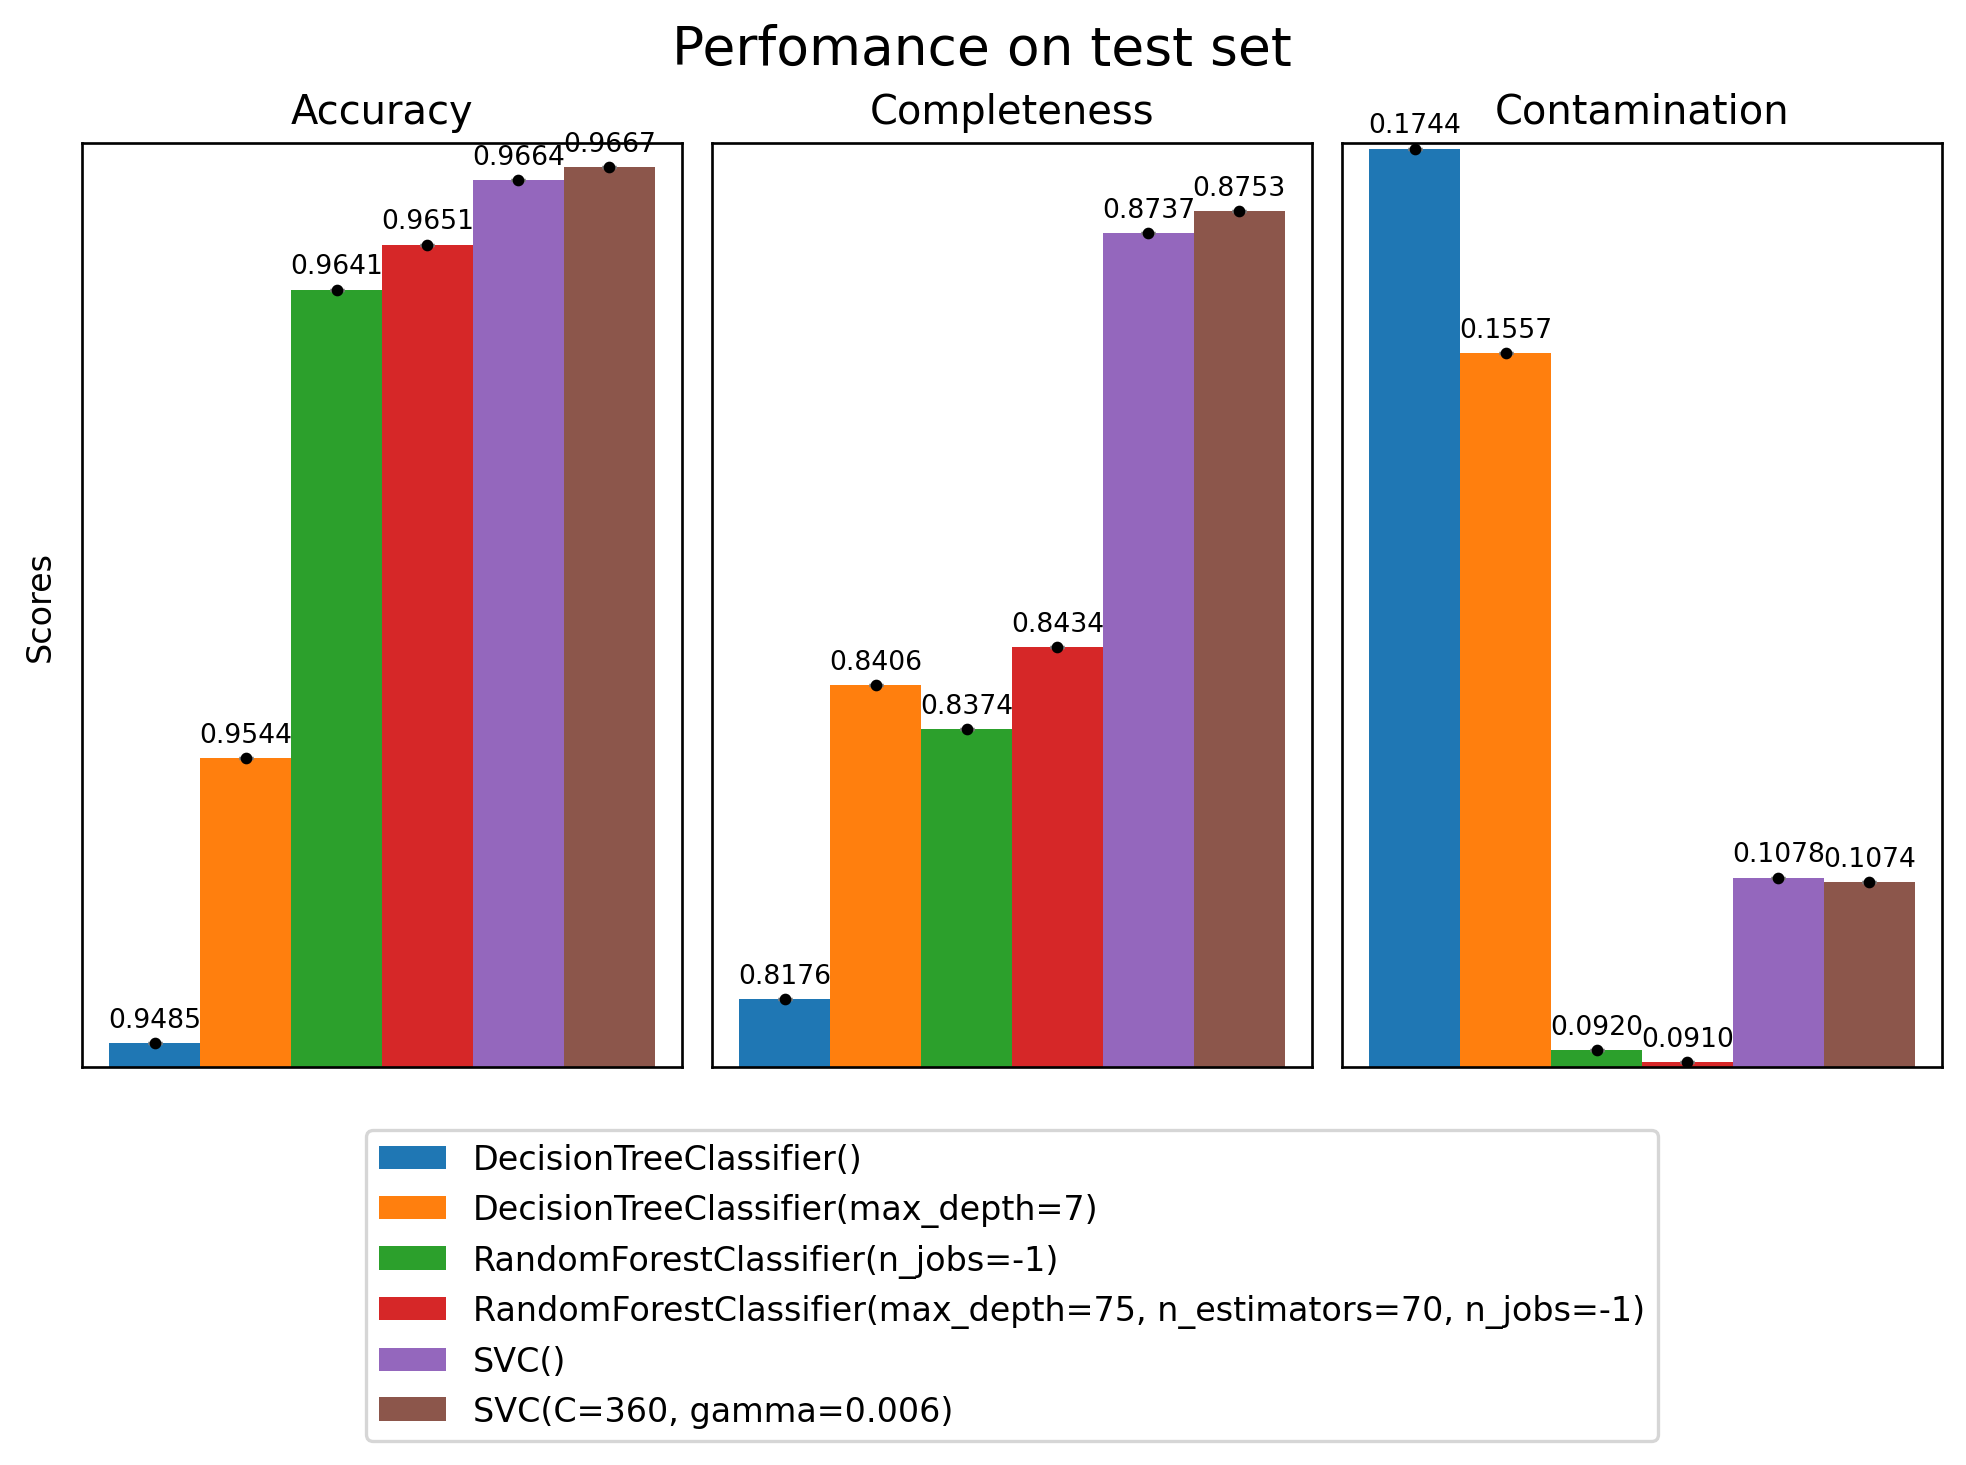

In [39]:
# Change colormap

# cmap=plt.cm.Blues_r
# c = cycler('color', cmap(np.linspace(0,0.5,len(info_list1))) )
# plt.rcParams["axes.prop_cycle"] = c

cmap=plt.cm.tab10
c = cycler('color', cmap(range(10)))
plt.rcParams["axes.prop_cycle"] = c

a1 = compare_classifiers(info_list_tot_t, figtitle='Perfomance on test set')

On the other hand, it seems that optimization thuough cross-validation helped to get better predictions on the test set.